# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
import pretrainedmodels

In [2]:
pretrainedmodels

<module 'pretrainedmodels' from '/home/dohee/.local/lib/python3.6/site-packages/pretrainedmodels/__init__.py'>

In [3]:
#!pip install ../input/pretrainedmodels/pretrainedmodels-0.7.4/ > /dev/null # no output
#!python -m pip install ../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4/ > /dev/null --user 
#!python -m pip install /home/dohee/Documents/kaggle/Bengali/pretrained-models.pytorch/ > /dev/null --user 


In [4]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
# import lightgbm as lgb
# import xgboost as xgb
# import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/bengaliaicv19feather/train_image_data_1.feather
../input/bengaliaicv19feather/train_image_data_3.feather
../input/bengaliaicv19feather/test_image_data_3.feather
../input/bengaliaicv19feather/test_image_data_2.feather
../input/bengaliaicv19feather/train_image_data_0.feather
../input/bengaliaicv19feather/test_image_data_1.feather
../input/bengaliaicv19feather/test_image_data_0.feather
../input/bengaliaicv19feather/train_image_data_2.feather
../input/bengaliai-cv19/class_map.csv
../input/bengaliai-cv19/train_image_data_1.parquet
../input/bengaliai-cv19/train_image_data_0.parquet
../input/bengaliai-cv19/test_image_data_1.parquet
../input/bengaliai-cv19/train_image_data_3.parquet
../input/bengaliai-cv19/test.csv
../input/bengaliai-cv19/test_image_data_2.parquet
../input/bengaliai-cv19/train.csv
../input/bengaliai-cv19/train_image_data_2.parquet
../input/bengaliai-cv19/test_image_data_3.parquet
../input/bengaliai-cv19/test_image_data_0.parquet
../input/bengaliai-cv19/sample_submissi

In [6]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the "../input/" directory.
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.

In [7]:
debug=False
submission=False
batch_size=32*3
device='cuda:0'
out='.'
image_size=64*2
arch='pretrained'
model_name='se_resnext50_32x4d'

In [8]:
datadir = Path('../input/bengaliai-cv19')
featherdir = Path('../input/bengaliaicv19feather')
outdir = Path('./save')

In [9]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [10]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [11]:
os.listdir(r"../input")

['bengaliaicv19feather', 'bengaliai-cv19']

In [12]:
%%time

train = pd.read_csv(datadir/'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)


image_df_list 4
CPU times: user 8.12 s, sys: 9.37 s, total: 17.5 s
Wall time: 37.2 s


In [13]:
os.listdir("../input/bengaliaicv19feather/")

['train_image_data_1.feather',
 'train_image_data_3.feather',
 'test_image_data_3.feather',
 'test_image_data_2.feather',
 'train_image_data_0.feather',
 'test_image_data_1.feather',
 'test_image_data_0.feather',
 'train_image_data_2.feather']

<a id="dataset"></a>
# Dataset

In [14]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [15]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        x = x.astype(np.double)
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [16]:
train_dataset = BengaliAIDataset(train_images, train_labels)

image, label = train_dataset[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


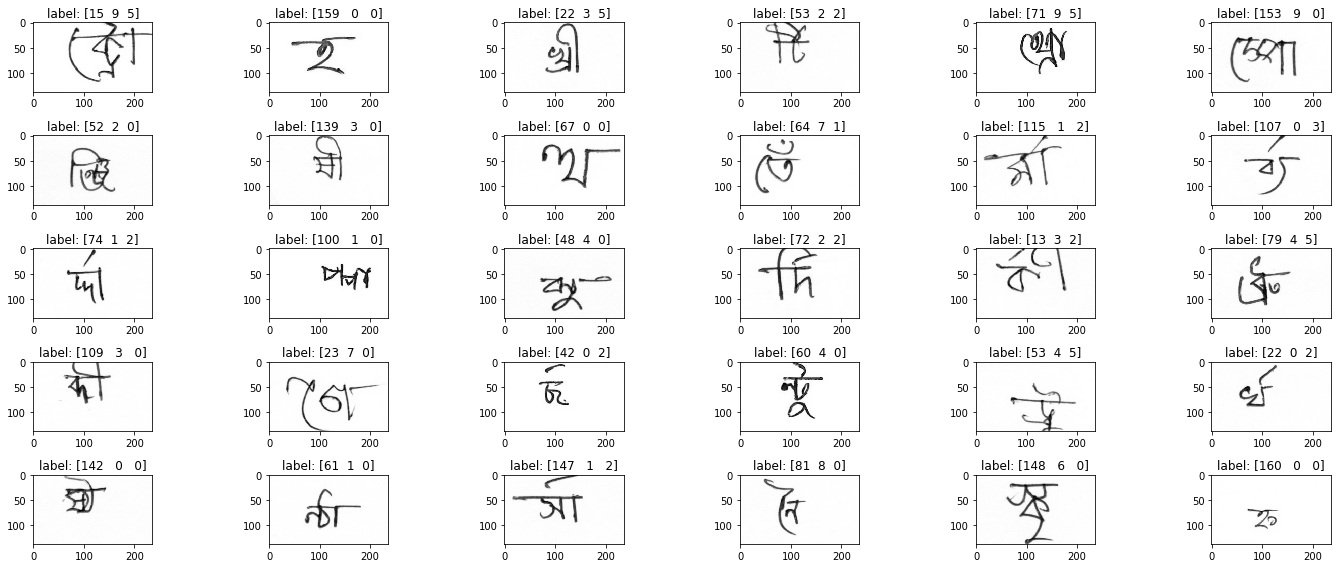

<Figure size 432x288 with 0 Axes>

In [17]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [18]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    
    #print("img.shape:", img.shape)
    
    # horizontal flip
    #if np.random.rand()<0.5:
    #img = img[:,::-1]
    
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 4
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    #tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
    #                        translation=(tx, ty))
    tform = AffineTransform(scale=(sx, sy), shear=shear_angle, rotation=rot_angle)
    
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image


from scipy.ndimage.measurements import label

def connected_comp(array):
    
    structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
    labeled, ncomponents = label(array, structure)
    
    valid = []
    for i in range(1,ncomponents+1):
        if np.sum(labeled == i)>10:
            valid.append(i)

    new_array = np.zeros(array.shape)
    for i in valid:
        new_array += labeled==i
    return new_array

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def crop_char_image(image, threshold=5./255.):
    assert image.ndim == 2
    
    image[image < 20./255.] = 0
    
    is_black = image > threshold
    is_black[:5,:] = 0
    is_black[-5:,:] = 0
    is_black[:,:5] = 0
    is_black[:,-5:] = 0
    #is_black = connected_comp(is_black)
    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left-5:height - right+5, top-5:width - bottom+5]
    
    lx, ly = height - right - left + 10, width - bottom - top + 10
    l = max(lx,ly)
    #make sure that the aspect ratio is kept in rescaling
    cropped_image = np.pad(cropped_image, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    
    # scaling
    cropped_image = cropped_image*(1/cropped_image.max())
    
    #pad
    cropped_image = np.pad(cropped_image, 8, pad_with)
    
    return cropped_image

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

In [19]:
# Erosion
def erosion(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 3, 2)))
    img = cv2.erode(img, kernel, iterations=1)
    return img

# Dilation
def dilation(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 3, 2)))
    img = cv2.dilate(img, kernel, iterations=1)
    return img


def get_random_kernel():
    structure = np.random.choice([cv2.MORPH_RECT, cv2.MORPH_ELLIPSE, cv2.MORPH_CROSS])
    kernel = cv2.getStructuringElement(structure, tuple(np.random.randint(1, 3, 2)))
    return kernel

# Opening
def opening(img):
    img = cv2.erode(img, get_random_kernel(), iterations=1)
    img = cv2.dilate(img, get_random_kernel(), iterations=1)
    return img

#Closing
def closing(img):
    img = cv2.dilate(img, get_random_kernel(), iterations=1)
    img = cv2.erode(img, get_random_kernel(), iterations=1)
    return img


## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

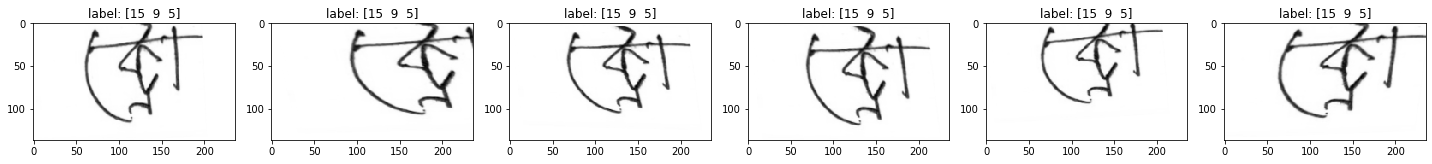

In [20]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[0]
    ax.imshow(affine_image(image), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

## crop image

Here I crop image

## resize image

We need to resize image after crop, to align image size for CNN batch training.

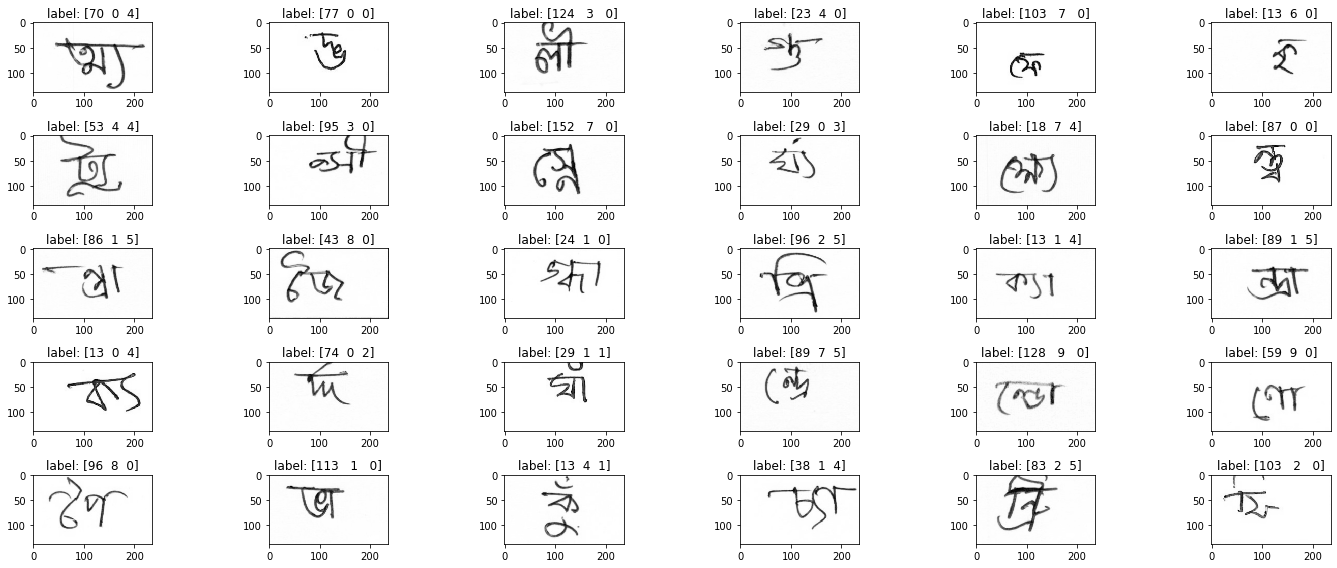

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i+30*5]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

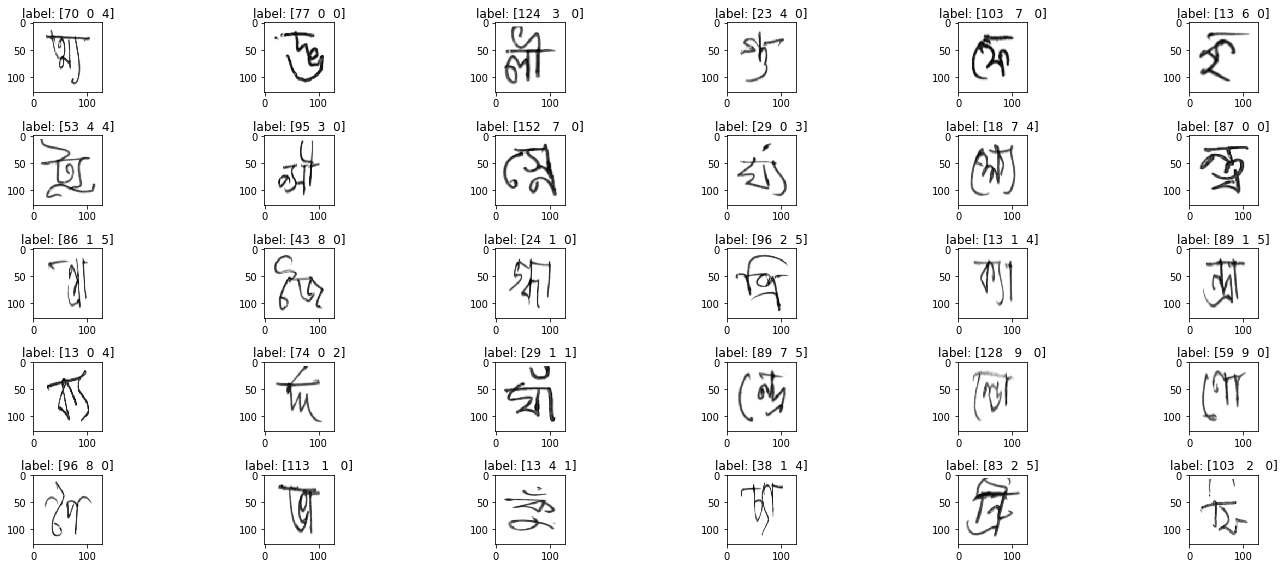

In [22]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i+30*5]
    ax.imshow(resize(crop_char_image(image, threshold=40./255.)), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [23]:
# class Transform:
#     def __init__(self, affine=True, crop=True, size=(64, 64),
#                  normalize=True, train=True, threshold=40.,
#                  sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
#                  grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
#                  piece_affine_ratio=0., ssr_ratio=0.):
#         self.affine = affine
#         self.crop = crop
#         self.size = size
#         self.normalize = normalize
#         self.train = train
#         self.threshold = threshold / 255.
#         self.sigma = sigma / 255.

#         self.blur_ratio = blur_ratio
#         self.noise_ratio = noise_ratio
#         self.cutout_ratio = cutout_ratio
#         self.grid_distortion_ratio = grid_distortion_ratio
#         self.elastic_distortion_ratio = elastic_distortion_ratio
#         self.random_brightness_ratio = random_brightness_ratio
#         self.piece_affine_ratio = piece_affine_ratio
#         self.ssr_ratio = ssr_ratio

#     def __call__(self, example):
        
        
#         if self.train:
#             x, y = example
#         else:
#             x = example
            
#         # --- Augmentation ---
#         if self.affine:
#             x = affine_image(x)

            
#         # --- Train/Test common preprocessing ---
#         if self.crop:
#             x = crop_char_image(x, threshold=self.threshold)
#         if self.size is not None:
#             x = resize(x, size=self.size)
#         #if self.sigma > 0.:
#         #    x = add_gaussian_noise(x, sigma=self.sigma)

        
#         #plt.imshow(x)
#         #plt.show()
        
#         # albumentations...
#         x = x.astype(np.float32)
#         assert x.ndim == 2
        
#         # 1. blur
#         if _evaluate_ratio(self.blur_ratio):
#             r = np.random.uniform()
#             if r < 0.25:
#                 x = apply_aug(A.Blur(p=1.0), x)
#             elif r < 0.5:
#                 x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
#             elif r < 0.75:
#                 x = apply_aug(A.GaussianBlur(p=1.0), x)
#             else:
#                 x = apply_aug(A.MotionBlur(p=1.0), x)
                

#         if _evaluate_ratio(self.noise_ratio):
#             r = np.random.uniform()
#             if r < 0.50:
#                 x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
#             else:
#                 x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

#         if _evaluate_ratio(self.cutout_ratio):
#             # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
#             x = apply_aug(A.Cutout(max_h_size=8, max_w_size=8, p=1.0), x)
#             #x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

#         if _evaluate_ratio(self.grid_distortion_ratio):
#             x = apply_aug(A.GridDistortion(p=1.0), x)

#         if _evaluate_ratio(self.elastic_distortion_ratio):
#             x = apply_aug(A.ElasticTransform(
#                 sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

#         if _evaluate_ratio(self.random_brightness_ratio):
#             # A.RandomBrightness(p=1.0)  # Deprecated...
#             # A.RandomContrast(p=1.0)    # Deprecated...
#             x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

#         if _evaluate_ratio(self.piece_affine_ratio):
#             x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

#         if _evaluate_ratio(self.ssr_ratio):
#             x = apply_aug(A.ShiftScaleRotate(
#                 shift_limit=0.0625,
#                 scale_limit=0.1,
#                 rotate_limit=30,
#                 p=1.0), x)
        
# #         # 난수생성
# #         const = np.random.rand(1)[0]
        
#         # Erosion, dilation
# #         if const<0.5:
# #             x = erosion(x)
# #         else:
# #             x = dilation(x)
        
        
        
# #         if const<0.15:
# #             x = erosion(x)
# #         elif const<0.3:
# #             x = dilation(x)
# #         elif const<0.45:
# #             x = opening(x)
# #         elif const<0.6:
# #             x = closing(x)
        
# #         plt.imshow(x)
# #         plt.show()

        
#         #if self.normalize:
#         #    x = (x.astype(np.double) - 0.0692) / 0.2051
#         if x.ndim == 2:
#             x = x[None, :, :]
#         x = x.astype(np.double)
#         if self.train:
#             y = y.astype(np.int64)
#             return x, y
#         else:
#             return x
        
#         # normalize by its max val
#         x = x * (255./x.max())

In [24]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']
        
        
class Transform:
    def __init__(self, affine=True, crop=False, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
                    
        # remove noise
        # x [x<28./255.] = 0
        
        # horizontal flip
        #x = x[:,:,::-1,:]

        
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
        
        

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
            x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.01,#0.0625,
                scale_limit=0.1,
                rotate_limit=30,
                p=1.0), x)

            
        #plt.imshow(x[0,0].cpu().numpy())
        #plt.show()
        
        #if self.normalize:
        #    x = (x.astype(np.float32) - 0.0692) / 0.2051
        # normalize by its max val
        # x = x * (255./x.max())
        
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x
        

In [25]:
# train_transform = Transform(
#     size=(image_size, image_size), threshold=20.,
#     sigma=-1., blur_ratio=0.1, noise_ratio=0, cutout_ratio=0.2,
#     grid_distortion_ratio=0.2, random_brightness_ratio=0.2,
#     piece_affine_ratio=0.2, ssr_ratio=0.2)
# train_dataset = BengaliAIDataset(train_images, train_labels,
#                                  transform=train_transform)

# for i in range(10):
#     train_dataset[0]

In [26]:
train_transform = Transform( crop=False, 
    size=(236, 137), threshold=40.,
    sigma=-1., blur_ratio=0, noise_ratio=0, cutout_ratio=0,
    grid_distortion_ratio=0, random_brightness_ratio=0,
    piece_affine_ratio=0.1, ssr_ratio=0.1)
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

In [27]:
class Cutout:
    def __init__(self, mask_size, p, cutout_inside, mask_color=1):
        self.p = p
        self.mask_size = mask_size
        self.cutout_inside = cutout_inside
        self.mask_color = mask_color

        self.mask_size_half = mask_size // 2
        self.offset = 1 if mask_size % 2 == 0 else 0

    def __call__(self, image):
        image_all = copy.copy(image)
        image = image[0,0]
        #image = np.asarray(image).copy()

        if np.random.random() > self.p:
            return image

        h, w = image.shape[:2]

        if self.cutout_inside:
            cxmin, cxmax = self.mask_size_half, w + self.offset - self.mask_size_half
            cymin, cymax = self.mask_size_half, h + self.offset - self.mask_size_half
        else:
            cxmin, cxmax = 0, w + self.offset
            cymin, cymax = 0, h + self.offset

        cx = np.random.randint(cxmin, cxmax)
        cy = np.random.randint(cymin, cymax)
        xmin = cx - self.mask_size_half
        ymin = cy - self.mask_size_half
        xmax = xmin + self.mask_size
        ymax = ymin + self.mask_size
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(w, xmax)
        ymax = min(h, ymax)
        
        
        image_all[:, :, ymin:ymax, xmin:xmax] = self.mask_color
        return image_all
    



In [28]:
cutout = Cutout(80, 1, True, 0) #32

### Let's final check the processed images, which will be trained by the model.

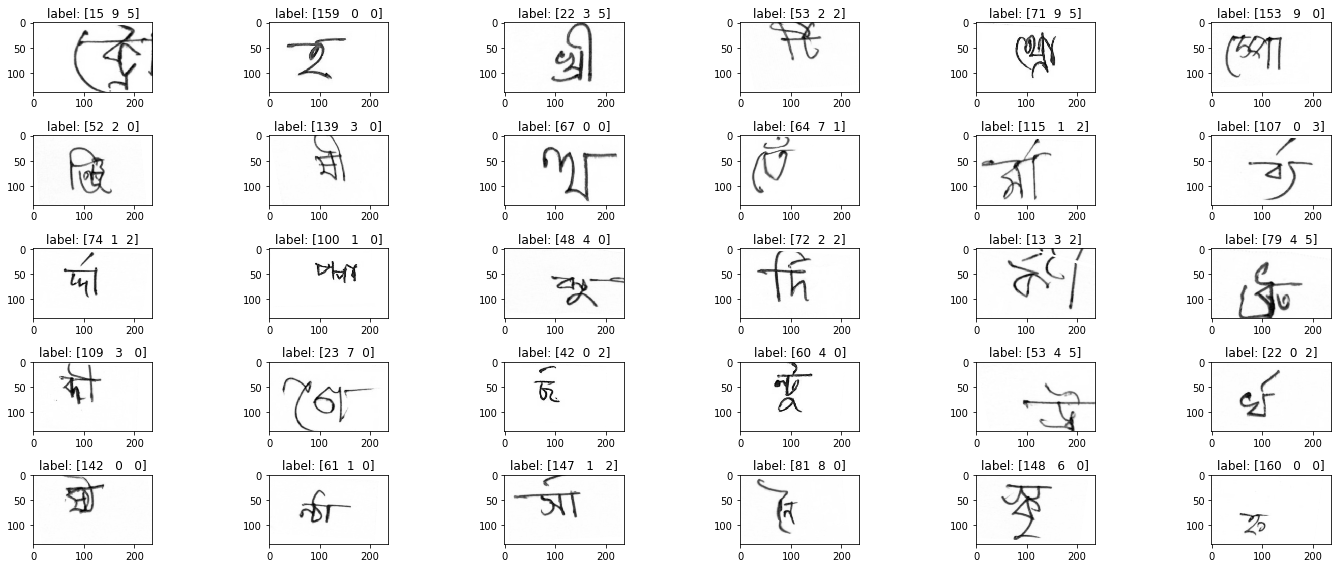

In [29]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [30]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [31]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [32]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [33]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [34]:
# GEM
# import torch.nn.functional as F

def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class GeM(nn.Module):

    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [35]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext50_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1_1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin1_2 = LinearBlock(hdim, 168, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers1 = Sequential(lin1_1, lin1_2)
        
        lin2_1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2_2 = LinearBlock(hdim, 11, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers2 = Sequential(lin2_1, lin2_2)

        lin3_1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin3_2 = LinearBlock(hdim, 7, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers3 = Sequential(lin3_1, lin3_2)

        self.pool = GeM()

    def forward(self, x):
        
        h = self.conv0(x)
        h = self.base_model.features(h)
        
        if self.do_pooling:
            
            #h1 = torch.sum(h, dim=(-1, -2))
            #h2 = torch.sum(h, dim=(-1, -2))
            #h3 = torch.sum(h, dim=(-1, -2))
            h1 = self.pool(h)[:,:,0,0]
            h2 = self.pool(h)[:,:,0,0]
            h3 = self.pool(h)[:,:,0,0]

            
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h1 = h.view(bs, ch*height*width)
            h2 = h.view(bs, ch*height*width)
            h3 = h.view(bs, ch*height*width)
        for layer in self.lin_layers1:
            h1 = layer(h1)
        for layer in self.lin_layers2:
            h2 = layer(h2)
        for layer in self.lin_layers3:
            h3 = layer(h3)
            
            
        return h1, h2, h3

## Classifier

In [36]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    while lam > 0.999:
        lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    
#     print(lam)
#     print(data.shape)
#     print(indices)
#     print(bbx1, bbx2, bby1, bby2)
    
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets

def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def cutmix_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

def mixup_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

In [37]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.double)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor.float()
        
        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']
        
    def forward(self, x, y=None):
        
        const = np.random.randint(6)
        if const<2:        
            # mixup
            data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
            x = data
        elif const<4:        
            # cutmix
            data, targets = cutmix(x, y[:,0], y[:,1], y[:,2], 0.4)
            x = data
        else:
            # cutout
            x = cutout(x)
        
        
        pred = self.predictor(x)
        
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_grapheme #self.n_total_class
            preds = pred #torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
            
        if const<4:
            # cutmix or mixup
            targets1, targets2, targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]        
            preds1, preds2, preds3 = preds[0], preds[1], preds[2]
            lam = float(lam)
            loss_grapheme = lam * F.cross_entropy(preds1, targets1) + (1 - lam) * F.cross_entropy(preds1, targets2) 
            loss_vowel = lam * F.cross_entropy(preds2, targets3) + (1 - lam) * F.cross_entropy(preds2, targets4)
            loss_consonant = lam * F.cross_entropy(preds3, targets5) + (1 - lam) * F.cross_entropy(preds3, targets6)
            loss = 2*loss_grapheme + loss_vowel + loss_consonant
            #loss = loss_grapheme + loss_vowel + loss_consonant
        else:
            loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
            loss_vowel = F.cross_entropy(preds[1], y[:, 1])
            loss_consonant = F.cross_entropy(preds[2], y[:, 2])
            loss = 2*loss_grapheme + loss_vowel + loss_consonant
            #loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    
    
    
    def forward_val(self, x, y=None):
        
        
        pred = self.predictor(x)
        #pred1 = self.predictor(x[:,:,::-1,:])
        #pred2 = self.predictor(x)
        #pred = (pred1+pred2)/2 
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = 2*loss_grapheme + loss_vowel + loss_consonant
        #loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels

<a id="train"></a>
# Training code

## prepare data

In [38]:
# iterative-stratification

import copy
import numpy as np
import pandas as pd
import iterstrat
#!pip install iterative-stratification

#get data
nfold = 10
seed = 22

train_df = copy.copy(train)
train_df['id'] = train_df['image_id'].apply(lambda x: int(x.split('_')[1]))

X, y = train_df[['id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic']]\
.values[:,0], train_df.values[:,1:]

train_df['fold'] = np.nan

#split data
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=nfold, random_state=seed)
for i, (_, test_index) in enumerate(mskf.split(X, y)):
    train_df.iloc[test_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

#------------------------------

n_dataset = len(train_images)
train_data_size = 200 if debug else int(n_dataset * 0.8)
valid_data_size = 100 if debug else int(n_dataset - train_data_size)

#perm = np.random.RandomState(777).permutation(n_dataset)
#print('perm', perm)
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=train_transform,
    indices = np.array(list(train_df[train_df['fold']!=1].index)))
    #    indices=perm[:train_data_size])
valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(affine=False, crop=False, size=(236, 137)),
    indices = np.array(list(train_df[train_df['fold']==1].index)))
#    indices=perm[train_data_size:train_data_size+valid_data_size])
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)
# Set pretrained='imagenet' to download imagenet pretrained model...
predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained='imagenet')
print('predictor', type(predictor))

/home/dohee/anaconda3/envs/Bengali/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



train_dataset 180756 valid_dataset 20084
n_total 186
predictor <class '__main__.PretrainedCNN'>


In [39]:
pretrainedmodels

<module 'pretrainedmodels' from '/home/dohee/.local/lib/python3.6/site-packages/pretrainedmodels/__init__.py'>

In [40]:
# #load weights
# predictor.load_state_dict(torch.load(r"/home/dohee/Documents/kaggle/Bengali/Bengali/save/model_000060.pt"))
# predictor.train()

classifier = BengaliClassifier(predictor).to(device)

In [41]:
predictor

PretrainedCNN(
  (conv0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (base_model): SENet(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(25

## Ignite utility

pytorch-ignite utility class for training

In [42]:
import json
from logging import getLogger
import numpy

def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

import os
from logging import getLogger
from time import perf_counter

import pandas as pd
import torch
# from chainer_chemistry.utils import save_json

from ignite.engine.engine import Engine, Events
from ignite.metrics import Average


class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


def create_trainer(classifier, optimizer, device):
    classifier.to(device)    
    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()

        # batch = [elem.to(device) for elem in batch]
        x, y = [elem.to(device) for elem in batch]
        x = x.float()
        
#         # mixup
#         data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
#         #print(data.shape)
#         print(len(targets))
#         print(targets[0].shape)
#         print(y.shape)
        
#         print(targets)
#         print(y)

        
        loss, metrics, pred_y = classifier(x, y)
        
#         print(pred_y.shape)
#         print(pred_y)
#         print("---------------")
        
        loss.backward()
        optimizer.step()
        return metrics, pred_y, y
    
    
    trainer = Engine(update_fn)
    
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
        
    return trainer


def create_evaluator(classifier, device):
    classifier.to(device)
    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            # batch = [elem.to(device) for elem in batch]
            x, y = [elem.to(device) for elem in batch]
            x = x.float()
            _, metrics, pred_y = classifier.forward_val(x, y)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        
        ####
        print(elem)
        
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    def __init__(self, model, filepath=r'./save/model_{count:06}.pt',
                 interval=10, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            print("saving model epoch:", self.count)
            
            #self.logger.warning(f'save model to {filepath}...')


import warnings

import torch

from ignite.metrics.metric import Metric


class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)


import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score


In [43]:
# def create_trainer(classifier, optimizer, device):
#     classifier.to(device)    
#     def update_fn(engine, batch):
#         classifier.train()
#         optimizer.zero_grad()

#         # batch = [elem.to(device) for elem in batch]
#         x, y = [elem.to(device) for elem in batch]        
#         x = x.float()
        
#         print(x.shape)
#         print(y.shape)
        
#         loss, metrics, pred_y = classifier(x, y)

In [44]:
# from ignite.handlers import ModelCheckpoint

# checkpoint_every = 10

# dirname = r"./save"
# engine_checkpoint = ModelCheckpoint(
#     dirname=dirname,
#     'my_model',
#     save_interval=checkpoint_every,
#     create_dir = True)

In [45]:
import argparse
from distutils.util import strtobool
import os

import torch
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

# --- Training setting ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


#optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

# AdamW
optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-10)

trainer = create_trainer(classifier, optimizer, device)
def output_transform(output):
    metric, pred_y, y = output
    #print(pred_y[0].shape)
    #print(pred_y[1].shape)
    pred_y = torch.cat((pred_y[0], pred_y[1], pred_y[2]), 1)
    
    return pred_y.cpu(), y.cpu()
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

pbar = ProgressBar()
pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)

def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator)
trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, outdir)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    ModelSnapshotHandler(predictor))
    #ModelSnapshotHandler(predictor, filepath=outdir / 'predictor.pt'))
#trainer.add_event_handler(Events.EPOCH_COMPLETED, engine_checkpoint, {'mymodel':classifier})

In [ ]:
trainer.run(train_loader, max_epochs=100)

/home/dohee/anaconda3/envs/Bengali/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



{'epoch': 1, 'iteration': 1883, 'train/loss': 7.229904765216708, 'train/loss_grapheme': 2.6929752242672778, 'train/loss_vowel': 1.0652621105606102, 'train/loss_consonant': 0.7786922097855025, 'train/acc_grapheme': 0.3641565827074326, 'train/acc_vowel': 0.6060340957944517, 'train/acc_consonant': 0.7423777596540464, 'train/recall': 0.4826930966626966, 'valid/loss': 1.7229724265280224, 'valid/loss_grapheme': 0.6127094355367478, 'valid/loss_vowel': 0.2666956871038392, 'valid/loss_consonant': 0.23085786842164538, 'valid/acc_grapheme': 0.8809523809523807, 'valid/acc_vowel': 0.9544444444444449, 'valid/acc_consonant': 0.9539682539682537, 'valid/recall': 0.9261087282840545, 'lr': 0.002, 'elapsed_time': 1479.2748781270002}
epoch      1 train/loss  7.229905 train/loss_grapheme  2.692975 train/loss_vowel  1.065262 train/loss_consonant  0.778692 train/acc_grapheme  0.364157 train/acc_vowel  0.606034 train/acc_consonant  0.742378 train/recall  0.482693 valid/loss  1.722972 valid/loss_grapheme  0.612

{'epoch': 2, 'iteration': 3766, 'train/loss': 5.348775890869975, 'train/loss_grapheme': 1.991184101450399, 'train/loss_vowel': 0.8346905521870419, 'train/loss_consonant': 0.5317171281535006, 'train/acc_grapheme': 0.46143675871835715, 'train/acc_vowel': 0.6480445337986489, 'train/acc_consonant': 0.7700335710492368, 'train/recall': 0.567327387611628, 'valid/loss': 0.9862283353294645, 'valid/loss_grapheme': 0.33864441485632035, 'valid/loss_vowel': 0.17911922041149367, 'valid/loss_consonant': 0.1298202831830297, 'valid/acc_grapheme': 0.92140873015873, 'valid/acc_vowel': 0.9738789682539686, 'valid/acc_consonant': 0.9739583333333334, 'valid/recall': 0.9417055024828926, 'lr': 0.002, 'elapsed_time': 2956.9276542040006}
epoch      2 train/loss  5.348776 train/loss_grapheme  1.991184 train/loss_vowel  0.834691 train/loss_consonant  0.531717 train/acc_grapheme  0.461437 train/acc_vowel  0.648045 train/acc_consonant  0.770034 train/recall  0.567327 valid/loss  0.986228 valid/loss_grapheme  0.33864

{'epoch': 3, 'iteration': 5649, 'train/loss': 4.977201391741499, 'train/loss_grapheme': 1.8491069613716036, 'train/loss_vowel': 0.7820869518035406, 'train/loss_consonant': 0.49690052133747953, 'train/acc_grapheme': 0.4895145790658276, 'train/acc_vowel': 0.6635095023139393, 'train/acc_consonant': 0.7809236147990798, 'train/recall': 0.59581127447668, 'valid/loss': 1.1686944476195744, 'valid/loss_grapheme': 0.3939768250499453, 'valid/loss_vowel': 0.21086255134571166, 'valid/loss_consonant': 0.16987824216485023, 'valid/acc_grapheme': 0.9242261904761904, 'valid/acc_vowel': 0.9786408730158733, 'valid/acc_consonant': 0.9690972222222229, 'valid/recall': 0.9519911724471062, 'lr': 0.002, 'elapsed_time': 4419.531014404001}
epoch      3 train/loss  4.977201 train/loss_grapheme  1.849107 train/loss_vowel  0.782087 train/loss_consonant  0.496901 train/acc_grapheme  0.489515 train/acc_vowel  0.663510 train/acc_consonant  0.780924 train/recall  0.595811 valid/loss  1.168694 valid/loss_grapheme  0.3939

{'epoch': 4, 'iteration': 7532, 'train/loss': 4.613779720352231, 'train/loss_grapheme': 1.7082539162164792, 'train/loss_vowel': 0.7318498985925952, 'train/loss_consonant': 0.4654219861850103, 'train/acc_grapheme': 0.5155645436613311, 'train/acc_vowel': 0.6753162696305279, 'train/acc_consonant': 0.7881696823710894, 'train/recall': 0.6145294926272632, 'valid/loss': 0.7770164037034625, 'valid/loss_grapheme': 0.2661261303439027, 'valid/loss_vowel': 0.13032202500672568, 'valid/loss_consonant': 0.11444211802667095, 'valid/acc_grapheme': 0.9429166666666671, 'valid/acc_vowel': 0.9833531746031748, 'valid/acc_consonant': 0.9798611111111114, 'valid/recall': 0.9618543854722863, 'lr': 0.002, 'elapsed_time': 5888.468080622999}
epoch      4 train/loss  4.613780 train/loss_grapheme  1.708254 train/loss_vowel  0.731850 train/loss_consonant  0.465422 train/acc_grapheme  0.515565 train/acc_vowel  0.675316 train/acc_consonant  0.788170 train/recall  0.614529 valid/loss  0.777016 valid/loss_grapheme  0.266

{'epoch': 5, 'iteration': 9415, 'train/loss': 4.48296503215411, 'train/loss_grapheme': 1.6616921945575445, 'train/loss_vowel': 0.7086645878823716, 'train/loss_consonant': 0.4509160496666434, 'train/acc_grapheme': 0.5029145487191149, 'train/acc_vowel': 0.6653634966997944, 'train/acc_consonant': 0.7813756543509611, 'train/recall': 0.5998122644101045, 'valid/loss': 0.7882437341269992, 'valid/loss_grapheme': 0.24802595827551116, 'valid/loss_vowel': 0.1723433829134419, 'valid/loss_consonant': 0.11984843558498791, 'valid/acc_grapheme': 0.9481944444444445, 'valid/acc_vowel': 0.9840873015873014, 'valid/acc_consonant': 0.9827876984126982, 'valid/recall': 0.9668460111914919, 'lr': 0.002, 'elapsed_time': 7357.1000298399995}
epoch      5 train/loss  4.482965 train/loss_grapheme  1.661692 train/loss_vowel  0.708665 train/loss_consonant  0.450916 train/acc_grapheme  0.502915 train/acc_vowel  0.665363 train/acc_consonant  0.781376 train/recall  0.599812 valid/loss  0.788244 valid/loss_grapheme  0.248

{'epoch': 6, 'iteration': 11298, 'train/loss': 4.255019685798545, 'train/loss_grapheme': 1.5743454072191179, 'train/loss_vowel': 0.6720444247941672, 'train/loss_consonant': 0.43428443957454527, 'train/acc_grapheme': 0.5223554105657132, 'train/acc_vowel': 0.677064366638848, 'train/acc_consonant': 0.7865954467288779, 'train/recall': 0.6151417001755599, 'valid/loss': 0.7848569986366091, 'valid/loss_grapheme': 0.2500409199368386, 'valid/loss_vowel': 0.16751805426818983, 'valid/loss_consonant': 0.11725710445926303, 'valid/acc_grapheme': 0.949226190476191, 'valid/acc_vowel': 0.9836805555555557, 'valid/acc_consonant': 0.9840773809523811, 'valid/recall': 0.9655802867091721, 'lr': 0.002, 'elapsed_time': 8836.920131713}
epoch      6 train/loss  4.255020 train/loss_grapheme  1.574345 train/loss_vowel  0.672044 train/loss_consonant  0.434284 train/acc_grapheme  0.522355 train/acc_vowel  0.677064 train/acc_consonant  0.786595 train/recall  0.615142 valid/loss  0.784857 valid/loss_grapheme  0.250041

{'epoch': 7, 'iteration': 13181, 'train/loss': 4.1241346351719255, 'train/loss_grapheme': 1.5228368183810599, 'train/loss_vowel': 0.6552546712442782, 'train/loss_consonant': 0.42320632388933, 'train/acc_grapheme': 0.5374252396125736, 'train/acc_vowel': 0.68590995877905, 'train/acc_consonant': 0.794612826543256, 'train/recall': 0.6293110277826056, 'valid/loss': 0.7143825271299907, 'valid/loss_grapheme': 0.2338242996661436, 'valid/loss_vowel': 0.1404224028899556, 'valid/loss_consonant': 0.10631152740901424, 'valid/acc_grapheme': 0.9500099206349208, 'valid/acc_vowel': 0.9852777777777779, 'valid/acc_consonant': 0.9841269841269847, 'valid/recall': 0.9681608289298743, 'lr': 0.002, 'elapsed_time': 10303.189668990999}
epoch      7 train/loss  4.124135 train/loss_grapheme  1.522837 train/loss_vowel  0.655255 train/loss_consonant  0.423206 train/acc_grapheme  0.537425 train/acc_vowel  0.685910 train/acc_consonant  0.794613 train/recall  0.629311 valid/loss  0.714383 valid/loss_grapheme  0.233824

{'epoch': 8, 'iteration': 15064, 'train/loss': 4.085090214086858, 'train/loss_grapheme': 1.5091370311795684, 'train/loss_vowel': 0.6474136265199503, 'train/loss_consonant': 0.4194025265916478, 'train/acc_grapheme': 0.5422728106112322, 'train/acc_vowel': 0.692074134486508, 'train/acc_consonant': 0.7987799673772853, 'train/recall': 0.6341330214644345, 'valid/loss': 0.7139401257038116, 'valid/loss_grapheme': 0.24067545043570654, 'valid/loss_vowel': 0.1302798612841538, 'valid/loss_consonant': 0.10230936365468161, 'valid/acc_grapheme': 0.9544742063492063, 'valid/acc_vowel': 0.9871527777777775, 'valid/acc_consonant': 0.9852678571428567, 'valid/recall': 0.9707107603246824, 'lr': 0.002, 'elapsed_time': 11770.524561718}
epoch      8 train/loss  4.085090 train/loss_grapheme  1.509137 train/loss_vowel  0.647414 train/loss_consonant  0.419403 train/acc_grapheme  0.542273 train/acc_vowel  0.692074 train/acc_consonant  0.798780 train/recall  0.634133 valid/loss  0.713940 valid/loss_grapheme  0.24067

{'epoch': 9, 'iteration': 16947, 'train/loss': 4.039807897344018, 'train/loss_grapheme': 1.4920231071649495, 'train/loss_vowel': 0.6426053497469447, 'train/loss_consonant': 0.4131563292560081, 'train/acc_grapheme': 0.5456962989656823, 'train/acc_vowel': 0.6952866183648183, 'train/acc_consonant': 0.8006387034367646, 'train/recall': 0.6386839276885654, 'valid/loss': 0.5281944528222084, 'valid/loss_grapheme': 0.17548279978689693, 'valid/loss_vowel': 0.1014371219135466, 'valid/loss_consonant': 0.07579173440379756, 'valid/acc_grapheme': 0.9566567460317459, 'valid/acc_vowel': 0.9865575396825396, 'valid/acc_consonant': 0.9875496031746035, 'valid/recall': 0.9739099236086018, 'lr': 0.002, 'elapsed_time': 13239.035256207}
epoch      9 train/loss  4.039808 train/loss_grapheme  1.492023 train/loss_vowel  0.642605 train/loss_consonant  0.413156 train/acc_grapheme  0.545696 train/acc_vowel  0.695287 train/acc_consonant  0.800639 train/recall  0.638684 valid/loss  0.528194 valid/loss_grapheme  0.1754

{'epoch': 10, 'iteration': 18830, 'train/loss': 3.9128870125058732, 'train/loss_grapheme': 1.4412431863675204, 'train/loss_vowel': 0.6246775052650172, 'train/loss_consonant': 0.40572313400033905, 'train/acc_grapheme': 0.5387513276686141, 'train/acc_vowel': 0.6872589649242595, 'train/acc_consonant': 0.7937371974812222, 'train/recall': 0.6279410933977889, 'valid/loss': 0.5395990114836465, 'valid/loss_grapheme': 0.18103382433099405, 'valid/loss_vowel': 0.09623717504243055, 'valid/loss_consonant': 0.08129418765505154, 'valid/acc_grapheme': 0.9571527777777777, 'valid/acc_vowel': 0.9867559523809529, 'valid/acc_consonant': 0.9868055555555559, 'valid/recall': 0.9722769835140498, 'lr': 0.002, 'elapsed_time': 14705.020151926}
epoch     10 train/loss  3.912887 train/loss_grapheme  1.441243 train/loss_vowel  0.624678 train/loss_consonant  0.405723 train/acc_grapheme  0.538751 train/acc_vowel  0.687259 train/acc_consonant  0.793737 train/recall  0.627941 valid/loss  0.539599 valid/loss_grapheme  0.

{'epoch': 11, 'iteration': 20713, 'train/loss': 3.846752629704888, 'train/loss_grapheme': 1.4165753406560047, 'train/loss_vowel': 0.6139385757885727, 'train/loss_consonant': 0.39966337074858516, 'train/acc_grapheme': 0.5401027046506329, 'train/acc_vowel': 0.6874968388842526, 'train/acc_consonant': 0.7931737285992452, 'train/recall': 0.6280857149198635, 'valid/loss': 0.5040185819069545, 'valid/loss_grapheme': 0.17020423635840415, 'valid/loss_vowel': 0.09361142982684431, 'valid/loss_consonant': 0.06999867907060044, 'valid/acc_grapheme': 0.961269841269841, 'valid/acc_vowel': 0.9890376984126985, 'valid/acc_consonant': 0.9875992063492065, 'valid/recall': 0.9750770493602847, 'lr': 0.002, 'elapsed_time': 16178.274862672002}
epoch     11 train/loss  3.846753 train/loss_grapheme  1.416575 train/loss_vowel  0.613939 train/loss_consonant  0.399663 train/acc_grapheme  0.540103 train/acc_vowel  0.687497 train/acc_consonant  0.793174 train/recall  0.628086 valid/loss  0.504019 valid/loss_grapheme  0

{'epoch': 12, 'iteration': 22596, 'train/loss': 3.8165114334113284, 'train/loss_grapheme': 1.3977066395122735, 'train/loss_vowel': 0.6172690206616365, 'train/loss_consonant': 0.4038291342568347, 'train/acc_grapheme': 0.5412952355663461, 'train/acc_vowel': 0.6819830627418251, 'train/acc_consonant': 0.7907689097944016, 'train/recall': 0.6264919078640112, 'valid/loss': 0.539252987787837, 'valid/loss_grapheme': 0.18368393732678323, 'valid/loss_vowel': 0.0933538391299191, 'valid/loss_consonant': 0.0785312760798704, 'valid/acc_grapheme': 0.9579960317460318, 'valid/acc_vowel': 0.9873511904761904, 'valid/acc_consonant': 0.9872023809523812, 'valid/recall': 0.9741757538999534, 'lr': 0.002, 'elapsed_time': 17651.722587781}
epoch     12 train/loss  3.816511 train/loss_grapheme  1.397707 train/loss_vowel  0.617269 train/loss_consonant  0.403829 train/acc_grapheme  0.541295 train/acc_vowel  0.681983 train/acc_consonant  0.790769 train/recall  0.626492 valid/loss  0.539253 valid/loss_grapheme  0.1836

{'epoch': 13, 'iteration': 24479, 'train/loss': 3.799607251656543, 'train/loss_grapheme': 1.3898962192728015, 'train/loss_vowel': 0.6174566633722375, 'train/loss_consonant': 0.40235815122347685, 'train/acc_grapheme': 0.5535453493665136, 'train/acc_vowel': 0.692427389171282, 'train/acc_consonant': 0.7976569810080172, 'train/recall': 0.6382451146338659, 'valid/loss': 0.5658202344462985, 'valid/loss_grapheme': 0.1798778754082464, 'valid/loss_vowel': 0.11891285163306055, 'valid/loss_consonant': 0.08715162935356299, 'valid/acc_grapheme': 0.9595337301587303, 'valid/acc_vowel': 0.9894841269841274, 'valid/acc_consonant': 0.9879464285714292, 'valid/recall': 0.9732072095211379, 'lr': 0.002, 'elapsed_time': 19121.821640372}
epoch     13 train/loss  3.799607 train/loss_grapheme  1.389896 train/loss_vowel  0.617457 train/loss_consonant  0.402358 train/acc_grapheme  0.553545 train/acc_vowel  0.692427 train/acc_consonant  0.797657 train/recall  0.638245 valid/loss  0.565820 valid/loss_grapheme  0.179

{'epoch': 14, 'iteration': 26362, 'train/loss': 3.7919383674733385, 'train/loss_grapheme': 1.3847725647390363, 'train/loss_vowel': 0.6191448643111164, 'train/loss_consonant': 0.40324837231609933, 'train/acc_grapheme': 0.5568265875123278, 'train/acc_vowel': 0.6952020585185739, 'train/acc_consonant': 0.7996619186708137, 'train/recall': 0.6408920823461174, 'valid/loss': 0.46132647203547616, 'valid/loss_grapheme': 0.1519430102691764, 'valid/loss_vowel': 0.08516149836636724, 'valid/loss_consonant': 0.0722789529711008, 'valid/acc_grapheme': 0.9644444444444444, 'valid/acc_vowel': 0.9890873015873021, 'valid/acc_consonant': 0.9886408730158738, 'valid/recall': 0.9780720086910679, 'lr': 0.002, 'elapsed_time': 20592.831802043}
epoch     14 train/loss  3.791938 train/loss_grapheme  1.384773 train/loss_vowel  0.619145 train/loss_consonant  0.403248 train/acc_grapheme  0.556827 train/acc_vowel  0.695202 train/acc_consonant  0.799662 train/recall  0.640892 valid/loss  0.461326 valid/loss_grapheme  0.1

{'epoch': 15, 'iteration': 28245, 'train/loss': 3.67236007371768, 'train/loss_grapheme': 1.3446072082307765, 'train/loss_vowel': 0.5956167230314308, 'train/loss_consonant': 0.3875289395415935, 'train/acc_grapheme': 0.5600540866904378, 'train/acc_vowel': 0.6981387350479223, 'train/acc_consonant': 0.8014084351212594, 'train/recall': 0.6463984118976918, 'valid/loss': 0.43844207660073325, 'valid/loss_grapheme': 0.14912044620584874, 'valid/loss_vowel': 0.07637807260311785, 'valid/loss_consonant': 0.06382311382996185, 'valid/acc_grapheme': 0.9638492063492062, 'valid/acc_vowel': 0.9896825396825404, 'valid/acc_consonant': 0.9886904761904768, 'valid/recall': 0.9764142972029078, 'lr': 0.002, 'elapsed_time': 22068.562965705}
epoch     15 train/loss  3.672360 train/loss_grapheme  1.344607 train/loss_vowel  0.595617 train/loss_consonant  0.387529 train/acc_grapheme  0.560054 train/acc_vowel  0.698139 train/acc_consonant  0.801408 train/recall  0.646398 valid/loss  0.438442 valid/loss_grapheme  0.14

{'epoch': 16, 'iteration': 30128, 'train/loss': 3.5956100819912353, 'train/loss_grapheme': 1.3093342853257997, 'train/loss_vowel': 0.5903138881544293, 'train/loss_consonant': 0.3866276272606704, 'train/acc_grapheme': 0.5704075310421562, 'train/acc_vowel': 0.7018467238196389, 'train/acc_consonant': 0.8029684457426096, 'train/recall': 0.6502516776412242, 'valid/loss': 0.49961764102890377, 'valid/loss_grapheme': 0.16916929316662607, 'valid/loss_vowel': 0.0893656732603198, 'valid/loss_consonant': 0.07191337978556042, 'valid/acc_grapheme': 0.9644940476190471, 'valid/acc_vowel': 0.9897321428571436, 'valid/acc_consonant': 0.9889880952380958, 'valid/recall': 0.9756048524419987, 'lr': 0.002, 'elapsed_time': 23551.643372480998}
epoch     16 train/loss  3.595610 train/loss_grapheme  1.309334 train/loss_vowel  0.590314 train/loss_consonant  0.386628 train/acc_grapheme  0.570408 train/acc_vowel  0.701847 train/acc_consonant  0.802968 train/recall  0.650252 valid/loss  0.499618 valid/loss_grapheme  

{'epoch': 17, 'iteration': 32011, 'train/loss': 3.504255332792622, 'train/loss_grapheme': 1.2751536911617583, 'train/loss_vowel': 0.576649370385147, 'train/loss_consonant': 0.3772985771836528, 'train/acc_grapheme': 0.569521628353943, 'train/acc_vowel': 0.6970038944946009, 'train/acc_consonant': 0.8002791265204962, 'train/recall': 0.6462844822883542, 'valid/loss': 0.4606340914964676, 'valid/loss_grapheme': 0.15796601197549276, 'valid/loss_vowel': 0.07243914444531713, 'valid/loss_consonant': 0.07226292430644944, 'valid/acc_grapheme': 0.962708333333333, 'valid/acc_vowel': 0.9890873015873017, 'valid/acc_consonant': 0.988244047619048, 'valid/recall': 0.9783249402611511, 'lr': 0.002, 'elapsed_time': 25022.494936360003}
epoch     17 train/loss  3.504255 train/loss_grapheme  1.275154 train/loss_vowel  0.576649 train/loss_consonant  0.377299 train/acc_grapheme  0.569522 train/acc_vowel  0.697004 train/acc_consonant  0.800279 train/recall  0.646284 valid/loss  0.460634 valid/loss_grapheme  0.157

{'epoch': 18, 'iteration': 33894, 'train/loss': 3.4755563653582153, 'train/loss_grapheme': 1.2654142053486246, 'train/loss_vowel': 0.570651640407286, 'train/loss_consonant': 0.3740763147551996, 'train/acc_grapheme': 0.5802986622158156, 'train/acc_vowel': 0.7095519434539617, 'train/acc_consonant': 0.8070707837038161, 'train/recall': 0.6591119039293909, 'valid/loss': 0.502507947456269, 'valid/loss_grapheme': 0.16850446845803943, 'valid/loss_vowel': 0.09681810360579264, 'valid/loss_consonant': 0.06868090693439756, 'valid/acc_grapheme': 0.9637003968253961, 'valid/acc_vowel': 0.9901785714285716, 'valid/acc_consonant': 0.9892361111111116, 'valid/recall': 0.9767966621805364, 'lr': 0.002, 'elapsed_time': 26511.274986899}
epoch     18 train/loss  3.475556 train/loss_grapheme  1.265414 train/loss_vowel  0.570652 train/loss_consonant  0.374076 train/acc_grapheme  0.580299 train/acc_vowel  0.709552 train/acc_consonant  0.807071 train/recall  0.659112 valid/loss  0.502508 valid/loss_grapheme  0.168

{'epoch': 19, 'iteration': 35777, 'train/loss': 3.598612733766935, 'train/loss_grapheme': 1.3089026281104654, 'train/loss_vowel': 0.5924160894549556, 'train/loss_consonant': 0.3883913866700768, 'train/acc_grapheme': 0.5676905520572545, 'train/acc_vowel': 0.7023556634549729, 'train/acc_consonant': 0.8026080785474028, 'train/recall': 0.6483734390948018, 'valid/loss': 0.44260325254428956, 'valid/loss_grapheme': 0.14574203693440982, 'valid/loss_vowel': 0.08395979984530381, 'valid/loss_consonant': 0.06715937946878728, 'valid/acc_grapheme': 0.9653571428571428, 'valid/acc_vowel': 0.9894841269841266, 'valid/acc_consonant': 0.9887400793650796, 'valid/recall': 0.978065165732936, 'lr': 0.002, 'elapsed_time': 27983.112649916002}
epoch     19 train/loss  3.598613 train/loss_grapheme  1.308903 train/loss_vowel  0.592416 train/loss_consonant  0.388391 train/acc_grapheme  0.567691 train/acc_vowel  0.702356 train/acc_consonant  0.802608 train/recall  0.648373 valid/loss  0.442603 valid/loss_grapheme  0

{'epoch': 20, 'iteration': 37660, 'train/loss': 3.4829340726374567, 'train/loss_grapheme': 1.2680258136984521, 'train/loss_vowel': 0.5721318435143488, 'train/loss_consonant': 0.37475059763886986, 'train/acc_grapheme': 0.5799145866525041, 'train/acc_vowel': 0.7115600422325062, 'train/acc_consonant': 0.8085738942417113, 'train/recall': 0.6616509846153449, 'valid/loss': 0.34940004086210613, 'valid/loss_grapheme': 0.12771865653672387, 'valid/loss_vowel': 0.047404755904738395, 'valid/loss_consonant': 0.04655797109894809, 'valid/acc_grapheme': 0.9655853174603175, 'valid/acc_vowel': 0.9901289682539685, 'valid/acc_consonant': 0.9884424603174612, 'valid/recall': 0.976696606547644, 'lr': 0.002, 'elapsed_time': 29481.923758456003}
epoch     20 train/loss  3.482934 train/loss_grapheme  1.268026 train/loss_vowel  0.572132 train/loss_consonant  0.374751 train/acc_grapheme  0.579915 train/acc_vowel  0.711560 train/acc_consonant  0.808574 train/recall  0.661651 valid/loss  0.349400 valid/loss_grapheme

{'epoch': 21, 'iteration': 39543, 'train/loss': 3.4890877682274475, 'train/loss_grapheme': 1.2644296972891211, 'train/loss_vowel': 0.5810096211131984, 'train/loss_consonant': 0.37921875684887596, 'train/acc_grapheme': 0.5755435538527676, 'train/acc_vowel': 0.701912316971398, 'train/acc_consonant': 0.8030316680575574, 'train/recall': 0.6507773635606251, 'valid/loss': 0.36331872514316016, 'valid/loss_grapheme': 0.13111375059400285, 'valid/loss_vowel': 0.0523320941343194, 'valid/loss_consonant': 0.04875912943056652, 'valid/acc_grapheme': 0.9672718253968252, 'valid/acc_vowel': 0.9907242063492065, 'valid/acc_consonant': 0.9894841269841272, 'valid/recall': 0.978910042019131, 'lr': 0.002, 'elapsed_time': 30974.584067026997}
epoch     21 train/loss  3.489088 train/loss_grapheme  1.264430 train/loss_vowel  0.581010 train/loss_consonant  0.379219 train/acc_grapheme  0.575544 train/acc_vowel  0.701912 train/acc_consonant  0.803032 train/recall  0.650777 valid/loss  0.363319 valid/loss_grapheme  0

{'epoch': 22, 'iteration': 41426, 'train/loss': 3.420962865230446, 'train/loss_grapheme': 1.243822414273682, 'train/loss_vowel': 0.5643524644224728, 'train/loss_consonant': 0.36896557583306944, 'train/acc_grapheme': 0.5816571517082674, 'train/acc_vowel': 0.7092065915585568, 'train/acc_consonant': 0.8077804541891103, 'train/recall': 0.6609192495524986, 'valid/loss': 0.43938882166431065, 'valid/loss_grapheme': 0.15062410632769266, 'valid/loss_vowel': 0.0813881356446516, 'valid/loss_consonant': 0.0567524738432396, 'valid/acc_grapheme': 0.9697519841269842, 'valid/acc_vowel': 0.9910218253968256, 'valid/acc_consonant': 0.9904761904761906, 'valid/recall': 0.9805268663451052, 'lr': 0.002, 'elapsed_time': 32454.830201376004}
epoch     22 train/loss  3.420963 train/loss_grapheme  1.243822 train/loss_vowel  0.564352 train/loss_consonant  0.368966 train/acc_grapheme  0.581657 train/acc_vowel  0.709207 train/acc_consonant  0.807780 train/recall  0.660919 valid/loss  0.439389 valid/loss_grapheme  0.

{'epoch': 23, 'iteration': 43309, 'train/loss': 3.4548357568297434, 'train/loss_grapheme': 1.2537933974860673, 'train/loss_vowel': 0.5719592358236435, 'train/loss_consonant': 0.37528973074251043, 'train/acc_grapheme': 0.5838335799003618, 'train/acc_vowel': 0.7092184457426105, 'train/acc_consonant': 0.8082783299193268, 'train/recall': 0.6593197592621024, 'valid/loss': 0.40016481578350066, 'valid/loss_grapheme': 0.1348451723655065, 'valid/loss_vowel': 0.07046689167618751, 'valid/loss_consonant': 0.06000757891507376, 'valid/acc_grapheme': 0.9686607142857139, 'valid/acc_vowel': 0.9907242063492068, 'valid/acc_consonant': 0.9888392857142861, 'valid/recall': 0.9814600262142473, 'lr': 0.002, 'elapsed_time': 33937.067319134}
epoch     23 train/loss  3.454836 train/loss_grapheme  1.253793 train/loss_vowel  0.571959 train/loss_consonant  0.375290 train/acc_grapheme  0.583834 train/acc_vowel  0.709218 train/acc_consonant  0.808278 train/recall  0.659320 valid/loss  0.400165 valid/loss_grapheme  0.

{'epoch': 24, 'iteration': 45192, 'train/loss': 3.409927023902132, 'train/loss_grapheme': 1.2391851296172582, 'train/loss_vowel': 0.5635069677763507, 'train/loss_consonant': 0.36804979481297606, 'train/acc_grapheme': 0.5936385706699043, 'train/acc_vowel': 0.7210568242166734, 'train/acc_consonant': 0.8151766747591229, 'train/recall': 0.6705223219195406, 'valid/loss': 0.4885449278922308, 'valid/loss_grapheme': 0.15628425040770144, 'valid/loss_vowel': 0.09584111346020585, 'valid/loss_consonant': 0.08013531468099072, 'valid/acc_grapheme': 0.9654861111111108, 'valid/acc_vowel': 0.9899801587301592, 'valid/acc_consonant': 0.9882440476190482, 'valid/recall': 0.9791858121682155, 'lr': 0.002, 'elapsed_time': 35423.524015298004}
epoch     24 train/loss  3.409927 train/loss_grapheme  1.239185 train/loss_vowel  0.563507 train/loss_consonant  0.368050 train/acc_grapheme  0.593639 train/acc_vowel  0.721057 train/acc_consonant  0.815177 train/recall  0.670522 valid/loss  0.488545 valid/loss_grapheme  

{'epoch': 25, 'iteration': 47075, 'train/loss': 3.3259907382848537, 'train/loss_grapheme': 1.2108343776851591, 'train/loss_vowel': 0.5432022179996736, 'train/loss_consonant': 0.36111976663704193, 'train/acc_grapheme': 0.5866390701261931, 'train/acc_vowel': 0.7162029309865221, 'train/acc_consonant': 0.8108103836330074, 'train/recall': 0.6668825352966636, 'valid/loss': 0.3546232355492456, 'valid/loss_grapheme': 0.12321780376313697, 'valid/loss_vowel': 0.05637135554459833, 'valid/loss_consonant': 0.05181627333873794, 'valid/acc_grapheme': 0.9680654761904762, 'valid/acc_vowel': 0.9902777777777784, 'valid/acc_consonant': 0.9903273809523815, 'valid/recall': 0.9793167314289993, 'lr': 0.002, 'elapsed_time': 36901.45194166}
epoch     25 train/loss  3.325991 train/loss_grapheme  1.210834 train/loss_vowel  0.543202 train/loss_consonant  0.361120 train/acc_grapheme  0.586639 train/acc_vowel  0.716203 train/acc_consonant  0.810810 train/recall  0.666883 valid/loss  0.354623 valid/loss_grapheme  0.1

{'epoch': 26, 'iteration': 48958, 'train/loss': 3.3179517098075837, 'train/loss_grapheme': 1.2032804120622824, 'train/loss_vowel': 0.5491215908564567, 'train/loss_consonant': 0.36226929762052984, 'train/acc_grapheme': 0.5935263510608705, 'train/acc_vowel': 0.7190906102217838, 'train/acc_consonant': 0.8138908909288618, 'train/recall': 0.670755262732035, 'valid/loss': 0.5171126914875848, 'valid/loss_grapheme': 0.17249889466024582, 'valid/loss_vowel': 0.09760428237773124, 'valid/loss_consonant': 0.07451062188262031, 'valid/acc_grapheme': 0.9657341269841261, 'valid/acc_vowel': 0.9909722222222226, 'valid/acc_consonant': 0.9900297619047627, 'valid/recall': 0.9811544059679667, 'lr': 0.002, 'elapsed_time': 38398.677467022004}
epoch     26 train/loss  3.317952 train/loss_grapheme  1.203280 train/loss_vowel  0.549122 train/loss_consonant  0.362269 train/acc_grapheme  0.593526 train/acc_vowel  0.719091 train/acc_consonant  0.813891 train/recall  0.670755 valid/loss  0.517113 valid/loss_grapheme  

{'epoch': 27, 'iteration': 50841, 'train/loss': 3.297595670501159, 'train/loss_grapheme': 1.1937433398500346, 'train/loss_vowel': 0.5488325718313503, 'train/loss_consonant': 0.36127641398026406, 'train/acc_grapheme': 0.601084578812937, 'train/acc_vowel': 0.7240646258503409, 'train/acc_consonant': 0.8162324874187584, 'train/recall': 0.6755079079530864, 'valid/loss': 0.3844391631228583, 'valid/loss_grapheme': 0.13290552608668804, 'valid/loss_vowel': 0.0649536426755644, 'valid/loss_consonant': 0.05367446898349694, 'valid/acc_grapheme': 0.9692658730158734, 'valid/acc_vowel': 0.9912202380952385, 'valid/acc_consonant': 0.9898809523809526, 'valid/recall': 0.9807968825209368, 'lr': 0.002, 'elapsed_time': 39884.460930389}
epoch     27 train/loss  3.297596 train/loss_grapheme  1.193743 train/loss_vowel  0.548833 train/loss_consonant  0.361276 train/acc_grapheme  0.601085 train/acc_vowel  0.724065 train/acc_consonant  0.816232 train/recall  0.675508 valid/loss  0.384439 valid/loss_grapheme  0.132

{'epoch': 28, 'iteration': 52724, 'train/loss': 3.3439817860350605, 'train/loss_grapheme': 1.2150775443997968, 'train/loss_vowel': 0.5532302340458973, 'train/loss_consonant': 0.3605964654201935, 'train/acc_grapheme': 0.5839157689097945, 'train/acc_vowel': 0.7105397921250302, 'train/acc_consonant': 0.8102018688516289, 'train/recall': 0.6617491969920153, 'valid/loss': 0.5362000696715854, 'valid/loss_grapheme': 0.16793876879272007, 'valid/loss_vowel': 0.11722050827173959, 'valid/loss_consonant': 0.08310202571252982, 'valid/acc_grapheme': 0.9695535714285708, 'valid/acc_vowel': 0.9911706349206357, 'valid/acc_consonant': 0.9903769841269849, 'valid/recall': 0.9783521528045258, 'lr': 0.002, 'elapsed_time': 41376.543915867}
epoch     28 train/loss  3.343982 train/loss_grapheme  1.215078 train/loss_vowel  0.553230 train/loss_consonant  0.360596 train/acc_grapheme  0.583916 train/acc_vowel  0.710540 train/acc_consonant  0.810202 train/recall  0.661749 valid/loss  0.536200 valid/loss_grapheme  0.1

{'epoch': 29, 'iteration': 54607, 'train/loss': 3.3717633306711075, 'train/loss_grapheme': 1.2203910305435297, 'train/loss_vowel': 0.5624124976710886, 'train/loss_consonant': 0.3685687721711378, 'train/acc_grapheme': 0.5847937688086394, 'train/acc_vowel': 0.7107318299066834, 'train/acc_consonant': 0.807755165263131, 'train/recall': 0.6620358482074005, 'valid/loss': 0.42012485755341394, 'valid/loss_grapheme': 0.14701343051024846, 'valid/loss_vowel': 0.06896928023724329, 'valid/loss_consonant': 0.05712871556835515, 'valid/acc_grapheme': 0.9677182539682538, 'valid/acc_vowel': 0.9908730158730167, 'valid/acc_consonant': 0.9891369047619054, 'valid/recall': 0.9779059242818546, 'lr': 0.002, 'elapsed_time': 42868.451445114}
epoch     29 train/loss  3.371763 train/loss_grapheme  1.220391 train/loss_vowel  0.562412 train/loss_consonant  0.368569 train/acc_grapheme  0.584794 train/acc_vowel  0.710732 train/acc_consonant  0.807755 train/recall  0.662036 valid/loss  0.420125 valid/loss_grapheme  0.1

{'epoch': 30, 'iteration': 56490, 'train/loss': 3.219857016377511, 'train/loss_grapheme': 1.1650824478777462, 'train/loss_vowel': 0.5360277628301545, 'train/loss_consonant': 0.3536643574471312, 'train/acc_grapheme': 0.5909966681840017, 'train/acc_vowel': 0.7114098892345033, 'train/acc_consonant': 0.8103559732443143, 'train/recall': 0.6665575087922341, 'valid/loss': 0.34544066793861844, 'valid/loss_grapheme': 0.12256576413554805, 'valid/loss_vowel': 0.05247364651766561, 'valid/loss_consonant': 0.04783549303455012, 'valid/acc_grapheme': 0.9676686507936507, 'valid/acc_vowel': 0.9906845238095245, 'valid/acc_consonant': 0.9911210317460319, 'valid/recall': 0.9795463189926339, 'lr': 0.002, 'elapsed_time': 44406.696614810004}
epoch     30 train/loss  3.219857 train/loss_grapheme  1.165082 train/loss_vowel  0.536028 train/loss_consonant  0.353664 train/acc_grapheme  0.590997 train/acc_vowel  0.711410 train/acc_consonant  0.810356 train/recall  0.666558 valid/loss  0.345441 valid/loss_grapheme  

{'epoch': 31, 'iteration': 58373, 'train/loss': 3.307097075779072, 'train/loss_grapheme': 1.1968684681175366, 'train/loss_vowel': 0.550791854517108, 'train/loss_consonant': 0.36256828868837826, 'train/acc_grapheme': 0.5773667273600891, 'train/acc_vowel': 0.70245207748527, 'train/acc_consonant': 0.804006081986698, 'train/recall': 0.6521063837406859, 'valid/loss': 0.3627790791647775, 'valid/loss_grapheme': 0.12403702782023521, 'valid/loss_vowel': 0.06543158331797236, 'valid/loss_consonant': 0.04927344212219829, 'valid/acc_grapheme': 0.9697123015873015, 'valid/acc_vowel': 0.9905257936507947, 'valid/acc_consonant': 0.9901289682539688, 'valid/recall': 0.980340299314206, 'lr': 0.002, 'elapsed_time': 45955.759628388}
epoch     31 train/loss  3.307097 train/loss_grapheme  1.196868 train/loss_vowel  0.550792 train/loss_consonant  0.362568 train/acc_grapheme  0.577367 train/acc_vowel  0.702452 train/acc_consonant  0.804006 train/recall  0.652106 valid/loss  0.362779 valid/loss_grapheme  0.124037

{'epoch': 32, 'iteration': 60256, 'train/loss': 3.2983653010623417, 'train/loss_grapheme': 1.1942597543894928, 'train/loss_vowel': 0.5480120036651124, 'train/loss_consonant': 0.3618337956340751, 'train/acc_grapheme': 0.5909579445160952, 'train/acc_vowel': 0.7159682181422757, 'train/acc_consonant': 0.8096139013226107, 'train/recall': 0.6651747889922148, 'valid/loss': 0.31726938936681975, 'valid/loss_grapheme': 0.11010757422163372, 'valid/loss_vowel': 0.04881119304114864, 'valid/loss_consonant': 0.048243047598572, 'valid/acc_grapheme': 0.9723809523809525, 'valid/acc_vowel': 0.9907738095238099, 'valid/acc_consonant': 0.98983134920635, 'valid/recall': 0.981767510368311, 'lr': 0.002, 'elapsed_time': 47516.403093686}
epoch     32 train/loss  3.298365 train/loss_grapheme  1.194260 train/loss_vowel  0.548012 train/loss_consonant  0.361834 train/acc_grapheme  0.590958 train/acc_vowel  0.715968 train/acc_consonant  0.809614 train/recall  0.665175 valid/loss  0.317269 valid/loss_grapheme  0.11010

{'epoch': 33, 'iteration': 62139, 'train/loss': 3.23612535067508, 'train/loss_grapheme': 1.1674666850275173, 'train/loss_vowel': 0.5441091520008465, 'train/loss_consonant': 0.3570828296321301, 'train/acc_grapheme': 0.6046605910022003, 'train/acc_vowel': 0.7238646852793169, 'train/acc_consonant': 0.8175403990592507, 'train/recall': 0.6779349083599311, 'valid/loss': 0.3446077366669973, 'valid/loss_grapheme': 0.11525303312532958, 'valid/loss_vowel': 0.05776453650600853, 'valid/loss_consonant': 0.056337133945808526, 'valid/acc_grapheme': 0.9721329365079364, 'valid/acc_vowel': 0.99186507936508, 'valid/acc_consonant': 0.9912202380952387, 'valid/recall': 0.98147338981795, 'lr': 0.002, 'elapsed_time': 49081.900746766}
epoch     33 train/loss  3.236125 train/loss_grapheme  1.167467 train/loss_vowel  0.544109 train/loss_consonant  0.357083 train/acc_grapheme  0.604661 train/acc_vowel  0.723865 train/acc_consonant  0.817540 train/recall  0.677935 valid/loss  0.344608 valid/loss_grapheme  0.115253

{'epoch': 34, 'iteration': 64022, 'train/loss': 3.301737480902222, 'train/loss_grapheme': 1.1932708296867456, 'train/loss_vowel': 0.551302439634566, 'train/loss_consonant': 0.36389339233754053, 'train/acc_grapheme': 0.5956869736742287, 'train/acc_vowel': 0.7186188136964826, 'train/acc_consonant': 0.8138442644715865, 'train/recall': 0.6700873522287518, 'valid/loss': 0.40584551223686766, 'valid/loss_grapheme': 0.135468347796372, 'valid/loss_vowel': 0.07305257840170747, 'valid/loss_consonant': 0.06185623739092123, 'valid/acc_grapheme': 0.9706944444444443, 'valid/acc_vowel': 0.9907242063492064, 'valid/acc_consonant': 0.9899801587301594, 'valid/recall': 0.9819958748076649, 'lr': 0.002, 'elapsed_time': 50581.658880825}
epoch     34 train/loss  3.301737 train/loss_grapheme  1.193271 train/loss_vowel  0.551302 train/loss_consonant  0.363893 train/acc_grapheme  0.595687 train/acc_vowel  0.718619 train/acc_consonant  0.813844 train/recall  0.670087 valid/loss  0.405846 valid/loss_grapheme  0.135

{'epoch': 35, 'iteration': 65905, 'train/loss': 3.1797120415319235, 'train/loss_grapheme': 1.1507903463125577, 'train/loss_vowel': 0.5298609143653237, 'train/loss_consonant': 0.34827044087724757, 'train/acc_grapheme': 0.6129363920289298, 'train/acc_vowel': 0.7309036997698698, 'train/acc_consonant': 0.8229711959133097, 'train/recall': 0.6858501644363604, 'valid/loss': 0.3372789165093785, 'valid/loss_grapheme': 0.1192664361071019, 'valid/loss_vowel': 0.053041271528317814, 'valid/loss_consonant': 0.0457047721459752, 'valid/acc_grapheme': 0.9713888888888887, 'valid/acc_vowel': 0.9916666666666673, 'valid/acc_consonant': 0.9912698412698416, 'valid/recall': 0.9823000331207206, 'lr': 0.002, 'elapsed_time': 52089.457822892}
epoch     35 train/loss  3.179712 train/loss_grapheme  1.150790 train/loss_vowel  0.529861 train/loss_consonant  0.348270 train/acc_grapheme  0.612936 train/acc_vowel  0.730904 train/acc_consonant  0.822971 train/recall  0.685850 valid/loss  0.337279 valid/loss_grapheme  0.1

{'epoch': 36, 'iteration': 67788, 'train/loss': 3.251164325606424, 'train/loss_grapheme': 1.1715920952525123, 'train/loss_vowel': 0.5476871198908768, 'train/loss_consonant': 0.3602930134789453, 'train/acc_grapheme': 0.5980127645853897, 'train/acc_vowel': 0.7179360126950404, 'train/acc_consonant': 0.8127615823280973, 'train/recall': 0.6720586148690364, 'valid/loss': 0.3241680367007142, 'valid/loss_grapheme': 0.11846920869180134, 'valid/loss_vowel': 0.046414352026546285, 'valid/loss_consonant': 0.040815266769468075, 'valid/acc_grapheme': 0.9700992063492064, 'valid/acc_vowel': 0.9900297619047624, 'valid/acc_consonant': 0.9900793650793653, 'valid/recall': 0.980266907429371, 'lr': 0.002, 'elapsed_time': 53606.270945936}
epoch     36 train/loss  3.251164 train/loss_grapheme  1.171592 train/loss_vowel  0.547687 train/loss_consonant  0.360293 train/acc_grapheme  0.598013 train/acc_vowel  0.717936 train/acc_consonant  0.812762 train/recall  0.672059 valid/loss  0.324168 valid/loss_grapheme  0.1

{'epoch': 37, 'iteration': 69671, 'train/loss': 3.279215546863958, 'train/loss_grapheme': 1.187709339042167, 'train/loss_vowel': 0.5440658735644529, 'train/loss_consonant': 0.3597309925112195, 'train/acc_grapheme': 0.5879548845560528, 'train/acc_vowel': 0.7142462003388711, 'train/acc_consonant': 0.8114299623195004, 'train/recall': 0.6641077884138898, 'valid/loss': 0.3799428186955906, 'valid/loss_grapheme': 0.13324915819934435, 'valid/loss_vowel': 0.05970057759966169, 'valid/loss_consonant': 0.05374392326034251, 'valid/acc_grapheme': 0.9714285714285713, 'valid/acc_vowel': 0.9913690476190476, 'valid/acc_consonant': 0.989880952380953, 'valid/recall': 0.9815419252197195, 'lr': 0.002, 'elapsed_time': 55115.170822251}
epoch     37 train/loss  3.279216 train/loss_grapheme  1.187709 train/loss_vowel  0.544066 train/loss_consonant  0.359731 train/acc_grapheme  0.587955 train/acc_vowel  0.714246 train/acc_consonant  0.811430 train/recall  0.664108 valid/loss  0.379943 valid/loss_grapheme  0.1332

{'epoch': 38, 'iteration': 71554, 'train/loss': 3.151869762453448, 'train/loss_grapheme': 1.1364088248603927, 'train/loss_vowel': 0.5292367267892738, 'train/loss_consonant': 0.34981538338286966, 'train/acc_grapheme': 0.6071262612851843, 'train/acc_vowel': 0.7226310598588872, 'train/acc_consonant': 0.8169287231621265, 'train/recall': 0.679487302015554, 'valid/loss': 0.3226685008832387, 'valid/loss_grapheme': 0.11598749985652311, 'valid/loss_vowel': 0.047097683121405894, 'valid/loss_consonant': 0.04359581756538578, 'valid/acc_grapheme': 0.9726785714285714, 'valid/acc_vowel': 0.9920138888888891, 'valid/acc_consonant': 0.9907242063492068, 'valid/recall': 0.9820993235966157, 'lr': 0.002, 'elapsed_time': 56626.443926742}
epoch     38 train/loss  3.151870 train/loss_grapheme  1.136409 train/loss_vowel  0.529237 train/loss_consonant  0.349815 train/acc_grapheme  0.607126 train/acc_vowel  0.722631 train/acc_consonant  0.816929 train/recall  0.679487 valid/loss  0.322669 valid/loss_grapheme  0.1

{'epoch': 39, 'iteration': 73437, 'train/loss': 3.257508927059028, 'train/loss_grapheme': 1.174605428240204, 'train/loss_vowel': 0.5484904974874107, 'train/loss_consonant': 0.35980757098027716, 'train/acc_grapheme': 0.584148110917229, 'train/acc_vowel': 0.7073004387628653, 'train/acc_consonant': 0.8056340565966162, 'train/recall': 0.6577249629406912, 'valid/loss': 0.40539475402661734, 'valid/loss_grapheme': 0.13453454047086694, 'valid/loss_vowel': 0.0723420727465834, 'valid/loss_consonant': 0.06398360019638424, 'valid/acc_grapheme': 0.9693055555555559, 'valid/acc_vowel': 0.9920138888888897, 'valid/acc_consonant': 0.9906250000000009, 'valid/recall': 0.9808990674518581, 'lr': 0.002, 'elapsed_time': 58152.98265824401}
epoch     39 train/loss  3.257509 train/loss_grapheme  1.174605 train/loss_vowel  0.548490 train/loss_consonant  0.359808 train/acc_grapheme  0.584148 train/acc_vowel  0.707300 train/acc_consonant  0.805634 train/recall  0.657725 valid/loss  0.405395 valid/loss_grapheme  0.1

{'epoch': 40, 'iteration': 75320, 'train/loss': 3.0744161229111766, 'train/loss_grapheme': 1.11179514447513, 'train/loss_vowel': 0.5115866509597082, 'train/loss_consonant': 0.3392391822009535, 'train/acc_grapheme': 0.5935097552031972, 'train/acc_vowel': 0.7135278367852704, 'train/acc_consonant': 0.8092053271122567, 'train/recall': 0.6649125313626731, 'valid/loss': 0.3635227043004263, 'valid/loss_grapheme': 0.12828343672943968, 'valid/loss_vowel': 0.05600489280408337, 'valid/loss_consonant': 0.05095093735449371, 'valid/acc_grapheme': 0.9670734126984125, 'valid/acc_vowel': 0.9914682539682543, 'valid/acc_consonant': 0.9899801587301591, 'valid/recall': 0.9795576342720481, 'lr': 0.002, 'elapsed_time': 59667.600012446994}
epoch     40 train/loss  3.074416 train/loss_grapheme  1.111795 train/loss_vowel  0.511587 train/loss_consonant  0.339239 train/acc_grapheme  0.593510 train/acc_vowel  0.713528 train/acc_consonant  0.809205 train/recall  0.664913 valid/loss  0.363523 valid/loss_grapheme  0.

{'epoch': 41, 'iteration': 77203, 'train/loss': 3.1504768189151617, 'train/loss_grapheme': 1.1383507445007484, 'train/loss_vowel': 0.5261790866583221, 'train/loss_consonant': 0.34759624333942407, 'train/acc_grapheme': 0.59940128467744, 'train/acc_vowel': 0.7179684141314526, 'train/acc_consonant': 0.8129567812255012, 'train/recall': 0.671832503788081, 'valid/loss': 0.3464844245995794, 'valid/loss_grapheme': 0.1282038920159851, 'valid/loss_vowel': 0.04583903691243558, 'valid/loss_consonant': 0.04423760441353633, 'valid/acc_grapheme': 0.9703373015873012, 'valid/acc_vowel': 0.9912698412698416, 'valid/acc_consonant': 0.9909722222222231, 'valid/recall': 0.981651738892197, 'lr': 0.002, 'elapsed_time': 61177.763491542}
epoch     41 train/loss  3.150477 train/loss_grapheme  1.138351 train/loss_vowel  0.526179 train/loss_consonant  0.347596 train/acc_grapheme  0.599401 train/acc_vowel  0.717968 train/acc_consonant  0.812957 train/recall  0.671833 valid/loss  0.346484 valid/loss_grapheme  0.12820

{'epoch': 42, 'iteration': 79086, 'train/loss': 3.1890202381836565, 'train/loss_grapheme': 1.1512705941283428, 'train/loss_vowel': 0.5338352167522866, 'train/loss_consonant': 0.35264383354216844, 'train/acc_grapheme': 0.5982585413347489, 'train/acc_vowel': 0.7174499911488758, 'train/acc_consonant': 0.8121309397364886, 'train/recall': 0.6717372341883324, 'valid/loss': 0.30582329694713867, 'valid/loss_grapheme': 0.10805968118920213, 'valid/loss_vowel': 0.04502716939009371, 'valid/loss_consonant': 0.04467676535160059, 'valid/acc_grapheme': 0.9726785714285711, 'valid/acc_vowel': 0.9916170634920642, 'valid/acc_consonant': 0.9905257936507943, 'valid/recall': 0.9821954073131585, 'lr': 0.002, 'elapsed_time': 62690.324884372}
epoch     42 train/loss  3.189020 train/loss_grapheme  1.151271 train/loss_vowel  0.533835 train/loss_consonant  0.352644 train/acc_grapheme  0.598259 train/acc_vowel  0.717450 train/acc_consonant  0.812131 train/recall  0.671737 valid/loss  0.305823 valid/loss_grapheme  0

{'epoch': 43, 'iteration': 80969, 'train/loss': 3.1729370234924876, 'train/loss_grapheme': 1.1415578401506548, 'train/loss_vowel': 0.5376382764083627, 'train/loss_consonant': 0.3521830632261817, 'train/acc_grapheme': 0.5955621096022058, 'train/acc_vowel': 0.7141861391396709, 'train/acc_consonant': 0.8100730533849224, 'train/recall': 0.6679551581163843, 'valid/loss': 0.3827355687816938, 'valid/loss_grapheme': 0.13266462901873247, 'valid/loss_vowel': 0.06623090260795185, 'valid/loss_consonant': 0.051175408686200775, 'valid/acc_grapheme': 0.9709325396825392, 'valid/acc_vowel': 0.9916170634920639, 'valid/acc_consonant': 0.9912202380952387, 'valid/recall': 0.9810099692998133, 'lr': 0.002, 'elapsed_time': 64217.479633972}
epoch     43 train/loss  3.172937 train/loss_grapheme  1.141558 train/loss_vowel  0.537638 train/loss_consonant  0.352183 train/acc_grapheme  0.595562 train/acc_vowel  0.714186 train/acc_consonant  0.810073 train/recall  0.667955 valid/loss  0.382736 valid/loss_grapheme  0.

{'epoch': 44, 'iteration': 82852, 'train/loss': 3.064174031232401, 'train/loss_grapheme': 1.1061439402233284, 'train/loss_vowel': 0.5123829418838823, 'train/loss_consonant': 0.3395032099192439, 'train/acc_grapheme': 0.6016796588523883, 'train/acc_vowel': 0.7183042826796152, 'train/acc_consonant': 0.8136300988796994, 'train/recall': 0.6723352744786907, 'valid/loss': 0.3445794893162591, 'valid/loss_grapheme': 0.11944781681966214, 'valid/loss_vowel': 0.05733847085918699, 'valid/loss_consonant': 0.048345386006292845, 'valid/acc_grapheme': 0.9722718253968254, 'valid/acc_vowel': 0.9914186507936515, 'valid/acc_consonant': 0.9914186507936509, 'valid/recall': 0.9812814319334061, 'lr': 0.002, 'elapsed_time': 65712.71801764201}
epoch     44 train/loss  3.064174 train/loss_grapheme  1.106144 train/loss_vowel  0.512383 train/loss_consonant  0.339503 train/acc_grapheme  0.601680 train/acc_vowel  0.718304 train/acc_consonant  0.813630 train/recall  0.672335 valid/loss  0.344579 valid/loss_grapheme  0

{'epoch': 45, 'iteration': 84735, 'train/loss': 3.265818842471564, 'train/loss_grapheme': 1.1805301074955497, 'train/loss_vowel': 0.5462763191349665, 'train/loss_consonant': 0.3584823042922913, 'train/acc_grapheme': 0.5944833788534004, 'train/acc_vowel': 0.7165577662291683, 'train/acc_consonant': 0.8135589737753821, 'train/recall': 0.6686435331060523, 'valid/loss': 0.4089121563803582, 'valid/loss_grapheme': 0.14174157240915866, 'valid/loss_vowel': 0.06554851872580392, 'valid/loss_consonant': 0.05988049168317091, 'valid/acc_grapheme': 0.9700000000000005, 'valid/acc_vowel': 0.9919146825396835, 'valid/acc_consonant': 0.9906746031746038, 'valid/recall': 0.9813010001788318, 'lr': 0.002, 'elapsed_time': 67215.329014366}
epoch     45 train/loss  3.265819 train/loss_grapheme  1.180530 train/loss_vowel  0.546276 train/loss_consonant  0.358482 train/acc_grapheme  0.594483 train/acc_vowel  0.716558 train/acc_consonant  0.813559 train/recall  0.668644 valid/loss  0.408912 valid/loss_grapheme  0.14

{'epoch': 46, 'iteration': 86618, 'train/loss': 3.128180586209148, 'train/loss_grapheme': 1.1268877975041254, 'train/loss_vowel': 0.5267728791976237, 'train/loss_consonant': 0.3476321163022939, 'train/acc_grapheme': 0.6068465025415367, 'train/acc_vowel': 0.7231178716839874, 'train/acc_consonant': 0.8153655514250312, 'train/recall': 0.6783844452670904, 'valid/loss': 0.3002656734415463, 'valid/loss_grapheme': 0.10626378266939095, 'valid/loss_vowel': 0.046956046377973897, 'valid/loss_consonant': 0.0407820629000309, 'valid/acc_grapheme': 0.9734623015873014, 'valid/acc_vowel': 0.991914682539683, 'valid/acc_consonant': 0.9910714285714294, 'valid/recall': 0.9823304366292065, 'lr': 0.002, 'elapsed_time': 68730.96967423099}
epoch     46 train/loss  3.128181 train/loss_grapheme  1.126888 train/loss_vowel  0.526773 train/loss_consonant  0.347632 train/acc_grapheme  0.606847 train/acc_vowel  0.723118 train/acc_consonant  0.815366 train/recall  0.678384 valid/loss  0.300266 valid/loss_grapheme  0.1

{'epoch': 47, 'iteration': 88501, 'train/loss': 3.07608809204603, 'train/loss_grapheme': 1.1083239526628847, 'train/loss_vowel': 0.5166387225086274, 'train/loss_consonant': 0.34280146809766665, 'train/acc_grapheme': 0.5971118465973747, 'train/acc_vowel': 0.7130023012922642, 'train/acc_consonant': 0.8085572983840384, 'train/recall': 0.6667701448964001, 'valid/loss': 0.2914654953139169, 'valid/loss_grapheme': 0.10204575169121935, 'valid/loss_vowel': 0.04327097901453574, 'valid/loss_consonant': 0.044103013005639825, 'valid/acc_grapheme': 0.9738591269841274, 'valid/acc_vowel': 0.9923611111111116, 'valid/acc_consonant': 0.9917162698412701, 'valid/recall': 0.9837097055613782, 'lr': 0.002, 'elapsed_time': 70233.301169877}
epoch     47 train/loss  3.076088 train/loss_grapheme  1.108324 train/loss_vowel  0.516639 train/loss_consonant  0.342801 train/acc_grapheme  0.597112 train/acc_vowel  0.713002 train/acc_consonant  0.808557 train/recall  0.666770 valid/loss  0.291465 valid/loss_grapheme  0.1

{'epoch': 48, 'iteration': 90384, 'train/loss': 3.1237130852508153, 'train/loss_grapheme': 1.1225156595676236, 'train/loss_vowel': 0.5282594213282973, 'train/loss_consonant': 0.3504223457176042, 'train/acc_grapheme': 0.6024738891839262, 'train/acc_vowel': 0.7180814240194221, 'train/acc_consonant': 0.8126296057456428, 'train/recall': 0.6737519321897314, 'valid/loss': 0.36894653049253284, 'valid/loss_grapheme': 0.13350352045326006, 'valid/loss_vowel': 0.05784783485744681, 'valid/loss_consonant': 0.044091653473497854, 'valid/acc_grapheme': 0.9692956349206352, 'valid/acc_vowel': 0.9911210317460323, 'valid/acc_consonant': 0.9904761904761912, 'valid/recall': 0.9790698004003578, 'lr': 0.002, 'elapsed_time': 71735.954451812}
epoch     48 train/loss  3.123713 train/loss_grapheme  1.122516 train/loss_vowel  0.528259 train/loss_consonant  0.350422 train/acc_grapheme  0.602474 train/acc_vowel  0.718081 train/acc_consonant  0.812630 train/recall  0.673752 valid/loss  0.368947 valid/loss_grapheme  0

{'epoch': 49, 'iteration': 92267, 'train/loss': 3.0799072292285654, 'train/loss_grapheme': 1.1100638423350442, 'train/loss_vowel': 0.5176781145979433, 'train/loss_consonant': 0.3421014290593814, 'train/acc_grapheme': 0.6071167779379414, 'train/acc_vowel': 0.7210030852489691, 'train/acc_consonant': 0.815530719722831, 'train/recall': 0.6773309878544663, 'valid/loss': 0.43610160237266904, 'valid/loss_grapheme': 0.15204406534986836, 'valid/loss_vowel': 0.0692801079579762, 'valid/loss_consonant': 0.06273336385687192, 'valid/acc_grapheme': 0.9690079365079367, 'valid/acc_vowel': 0.9919642857142863, 'valid/acc_consonant': 0.990873015873017, 'valid/recall': 0.9808339242779764, 'lr': 0.002, 'elapsed_time': 73234.575929001}
epoch     49 train/loss  3.079907 train/loss_grapheme  1.110064 train/loss_vowel  0.517678 train/loss_consonant  0.342101 train/acc_grapheme  0.607117 train/acc_vowel  0.721003 train/acc_consonant  0.815531 train/recall  0.677331 valid/loss  0.436102 valid/loss_grapheme  0.152

{'epoch': 50, 'iteration': 94150, 'train/loss': 3.0084173933771527, 'train/loss_grapheme': 1.0804268700237358, 'train/loss_vowel': 0.5093461181454072, 'train/loss_consonant': 0.33821753492016016, 'train/acc_grapheme': 0.6213165098753253, 'train/acc_vowel': 0.7331125293983751, 'train/acc_consonant': 0.8218015830867665, 'train/recall': 0.6906100284181906, 'valid/loss': 0.5122919603472664, 'valid/loss_grapheme': 0.17049038002178782, 'valid/loss_vowel': 0.09105608905000347, 'valid/loss_consonant': 0.08025511185682956, 'valid/acc_grapheme': 0.9699503968253972, 'valid/acc_vowel': 0.9918154761904766, 'valid/acc_consonant': 0.9905753968253976, 'valid/recall': 0.9819909155999442, 'lr': 0.002, 'elapsed_time': 74755.95857382801}
epoch     50 train/loss  3.008417 train/loss_grapheme  1.080427 train/loss_vowel  0.509346 train/loss_consonant  0.338218 train/acc_grapheme  0.621317 train/acc_vowel  0.733113 train/acc_consonant  0.821802 train/recall  0.690610 valid/loss  0.512292 valid/loss_grapheme  

{'epoch': 51, 'iteration': 96033, 'train/loss': 3.1125661197671914, 'train/loss_grapheme': 1.1193802693163342, 'train/loss_vowel': 0.526421862027736, 'train/loss_consonant': 0.347383720334372, 'train/acc_grapheme': 0.5950934741926511, 'train/acc_vowel': 0.7114470323445368, 'train/acc_consonant': 0.8107590155021103, 'train/recall': 0.6644091169922514, 'valid/loss': 0.34295590278648197, 'valid/loss_grapheme': 0.12139150697205747, 'valid/loss_vowel': 0.04884045034469593, 'valid/loss_consonant': 0.05133243808966308, 'valid/acc_grapheme': 0.9694543650793643, 'valid/acc_vowel': 0.992509920634921, 'valid/acc_consonant': 0.9906250000000009, 'valid/recall': 0.9805665181997435, 'lr': 0.002, 'elapsed_time': 76263.873677042}
epoch     51 train/loss  3.112566 train/loss_grapheme  1.119380 train/loss_vowel  0.526422 train/loss_consonant  0.347384 train/acc_grapheme  0.595093 train/acc_vowel  0.711447 train/acc_consonant  0.810759 train/recall  0.664409 valid/loss  0.342956 valid/loss_grapheme  0.121

{'epoch': 52, 'iteration': 97916, 'train/loss': 3.159301269706487, 'train/loss_grapheme': 1.1374675360930153, 'train/loss_vowel': 0.533813122482362, 'train/loss_consonant': 0.3505530720368914, 'train/acc_grapheme': 0.5976421237640036, 'train/acc_vowel': 0.7157271830665357, 'train/acc_consonant': 0.8110822395872848, 'train/recall': 0.6702545860861195, 'valid/loss': 0.3650314631916228, 'valid/loss_grapheme': 0.12706606718046323, 'valid/loss_vowel': 0.06201284720251957, 'valid/loss_consonant': 0.048886482133751824, 'valid/acc_grapheme': 0.9682142857142852, 'valid/acc_vowel': 0.989940476190477, 'valid/acc_consonant': 0.9893353174603182, 'valid/recall': 0.9792686023266368, 'lr': 0.002, 'elapsed_time': 77766.49761837599}
epoch     52 train/loss  3.159301 train/loss_grapheme  1.137468 train/loss_vowel  0.533813 train/loss_consonant  0.350553 train/acc_grapheme  0.597642 train/acc_vowel  0.715727 train/acc_consonant  0.811082 train/recall  0.670255 valid/loss  0.365031 valid/loss_grapheme  0.1

{'epoch': 53, 'iteration': 99799, 'train/loss': 3.0410083671453085, 'train/loss_grapheme': 1.0917162859116978, 'train/loss_vowel': 0.5152973253002952, 'train/loss_consonant': 0.34227846876188395, 'train/acc_grapheme': 0.6019175328123813, 'train/acc_vowel': 0.7146413398072972, 'train/acc_consonant': 0.8097103153529062, 'train/recall': 0.6694768725949427, 'valid/loss': 0.3625728394304003, 'valid/loss_grapheme': 0.12097253387882596, 'valid/loss_vowel': 0.0649338221443551, 'valid/loss_consonant': 0.05569394888090236, 'valid/acc_grapheme': 0.9739583333333335, 'valid/acc_vowel': 0.9913194444444451, 'valid/acc_consonant': 0.9910218253968257, 'valid/recall': 0.9815191651539065, 'lr': 0.002, 'elapsed_time': 79284.573233045}
epoch     53 train/loss  3.041008 train/loss_grapheme  1.091716 train/loss_vowel  0.515297 train/loss_consonant  0.342278 train/acc_grapheme  0.601918 train/acc_vowel  0.714641 train/acc_consonant  0.809710 train/recall  0.669477 valid/loss  0.362573 valid/loss_grapheme  0.1

{'epoch': 54, 'iteration': 101682, 'train/loss': 3.1184202809078667, 'train/loss_grapheme': 1.1232820594078894, 'train/loss_vowel': 0.5247223968471713, 'train/loss_consonant': 0.3471337663053287, 'train/acc_grapheme': 0.6072416420099648, 'train/acc_vowel': 0.7240377563664865, 'train/acc_consonant': 0.8167880535113662, 'train/recall': 0.6796998300946469, 'valid/loss': 0.33615043603238604, 'valid/loss_grapheme': 0.11740847455248946, 'valid/loss_vowel': 0.054824796691536906, 'valid/loss_consonant': 0.04650869177033504, 'valid/acc_grapheme': 0.971279761904762, 'valid/acc_vowel': 0.9915674603174605, 'valid/acc_consonant': 0.9919146825396827, 'valid/recall': 0.9815382920001438, 'lr': 0.002, 'elapsed_time': 80805.756391011}
epoch     54 train/loss  3.118420 train/loss_grapheme  1.123282 train/loss_vowel  0.524722 train/loss_consonant  0.347134 train/acc_grapheme  0.607242 train/acc_vowel  0.724038 train/acc_consonant  0.816788 train/recall  0.679700 valid/loss  0.336150 valid/loss_grapheme  0

{'epoch': 55, 'iteration': 103565, 'train/loss': 3.148558386809732, 'train/loss_grapheme': 1.1345333867655416, 'train/loss_vowel': 0.5285177030316215, 'train/loss_consonant': 0.35097391722032395, 'train/acc_grapheme': 0.5993815277040191, 'train/acc_vowel': 0.7211556090837833, 'train/acc_consonant': 0.8116378056798921, 'train/recall': 0.668607502928047, 'valid/loss': 0.3129640219467027, 'valid/loss_grapheme': 0.1056438277165095, 'valid/loss_vowel': 0.055003091630836325, 'valid/loss_consonant': 0.04667327507798161, 'valid/acc_grapheme': 0.9759027777777778, 'valid/acc_vowel': 0.9924603174603179, 'valid/acc_consonant': 0.991369047619048, 'valid/recall': 0.986066061001781, 'lr': 0.002, 'elapsed_time': 82307.315032577}
epoch     55 train/loss  3.148558 train/loss_grapheme  1.134533 train/loss_vowel  0.528518 train/loss_consonant  0.350974 train/acc_grapheme  0.599382 train/acc_vowel  0.721156 train/acc_consonant  0.811638 train/recall  0.668608 valid/loss  0.312964 valid/loss_grapheme  0.105

{'epoch': 56, 'iteration': 105448, 'train/loss': 3.1150578888161853, 'train/loss_grapheme': 1.120072874200515, 'train/loss_vowel': 0.5266426325915653, 'train/loss_consonant': 0.3482695077029089, 'train/acc_grapheme': 0.6021064094782901, 'train/acc_vowel': 0.7192020395518812, 'train/acc_consonant': 0.8148202589586022, 'train/recall': 0.67284790219553, 'valid/loss': 0.40516935948814664, 'valid/loss_grapheme': 0.14082039493535245, 'valid/loss_vowel': 0.06813295632600784, 'valid/loss_consonant': 0.0553956137526603, 'valid/acc_grapheme': 0.9691468253968257, 'valid/acc_vowel': 0.9923115079365086, 'valid/acc_consonant': 0.9900793650793656, 'valid/recall': 0.9797331139712993, 'lr': 0.002, 'elapsed_time': 83812.996549648}
epoch     56 train/loss  3.115058 train/loss_grapheme  1.120073 train/loss_vowel  0.526643 train/loss_consonant  0.348270 train/acc_grapheme  0.602106 train/acc_vowel  0.719202 train/acc_consonant  0.814820 train/recall  0.672848 valid/loss  0.405169 valid/loss_grapheme  0.140

{'epoch': 57, 'iteration': 107331, 'train/loss': 3.012999232745652, 'train/loss_grapheme': 1.0789888074371292, 'train/loss_vowel': 0.5159180823093319, 'train/loss_consonant': 0.33910353242138236, 'train/acc_grapheme': 0.6080556293149236, 'train/acc_vowel': 0.7191040449637105, 'train/acc_consonant': 0.8128042573906898, 'train/recall': 0.675874987362639, 'valid/loss': 0.355605699973447, 'valid/loss_grapheme': 0.1146330121549822, 'valid/loss_vowel': 0.07024535208585717, 'valid/loss_consonant': 0.056094322859176565, 'valid/acc_grapheme': 0.9771428571428571, 'valid/acc_vowel': 0.9937003968253978, 'valid/acc_consonant': 0.9924107142857151, 'valid/recall': 0.9854087243084672, 'lr': 0.0014, 'elapsed_time': 85318.717941704}
epoch     57 train/loss  3.012999 train/loss_grapheme  1.078989 train/loss_vowel  0.515918 train/loss_consonant  0.339104 train/acc_grapheme  0.608056 train/acc_vowel  0.719104 train/acc_consonant  0.812804 train/recall  0.675875 valid/loss  0.355606 valid/loss_grapheme  0.1

{'epoch': 58, 'iteration': 109214, 'train/loss': 2.9864508421677134, 'train/loss_grapheme': 1.068916946261789, 'train/loss_vowel': 0.510687311669585, 'train/loss_consonant': 0.3379296352874153, 'train/acc_grapheme': 0.6119833156310859, 'train/acc_vowel': 0.7219964658725941, 'train/acc_consonant': 0.8144606820423334, 'train/recall': 0.6763820649338582, 'valid/loss': 0.28842486909457615, 'valid/loss_grapheme': 0.10034583129343533, 'valid/loss_vowel': 0.04505687884631611, 'valid/loss_consonant': 0.042676325124644095, 'valid/acc_grapheme': 0.9763492063492067, 'valid/acc_vowel': 0.993055555555556, 'valid/acc_consonant': 0.9914682539682541, 'valid/recall': 0.9843174733800616, 'lr': 0.0014, 'elapsed_time': 86800.94918244501}
epoch     58 train/loss  2.986451 train/loss_grapheme  1.068917 train/loss_vowel  0.510687 train/loss_consonant  0.337930 train/acc_grapheme  0.611983 train/acc_vowel  0.721996 train/acc_consonant  0.814461 train/recall  0.676382 valid/loss  0.288425 valid/loss_grapheme  

{'epoch': 59, 'iteration': 111097, 'train/loss': 2.919650628883837, 'train/loss_grapheme': 1.044040589617586, 'train/loss_vowel': 0.49925532617343593, 'train/loss_consonant': 0.3323141226947577, 'train/acc_grapheme': 0.6148069822724631, 'train/acc_vowel': 0.7260577093290846, 'train/acc_consonant': 0.8169176592570099, 'train/recall': 0.6793688659689138, 'valid/loss': 0.27824467484440124, 'valid/loss_grapheme': 0.09599707131052301, 'valid/loss_vowel': 0.044836034616898925, 'valid/loss_consonant': 0.04141449789028792, 'valid/acc_grapheme': 0.9781746031746034, 'valid/acc_vowel': 0.9931051587301595, 'valid/acc_consonant': 0.9930059523809533, 'valid/recall': 0.9867318602472712, 'lr': 0.0014, 'elapsed_time': 88311.65649555699}
epoch     59 train/loss  2.919651 train/loss_grapheme  1.044041 train/loss_vowel  0.499255 train/loss_consonant  0.332314 train/acc_grapheme  0.614807 train/acc_vowel  0.726058 train/acc_consonant  0.816918 train/recall  0.679369 valid/loss  0.278245 valid/loss_grapheme

{'epoch': 60, 'iteration': 112980, 'train/loss': 2.902592928349117, 'train/loss_grapheme': 1.0390244012929013, 'train/loss_vowel': 0.4964141556980762, 'train/loss_consonant': 0.328129967918943, 'train/acc_grapheme': 0.6194704182788349, 'train/acc_vowel': 0.726854310497433, 'train/acc_consonant': 0.8187669119692496, 'train/recall': 0.6848306234161532, 'valid/loss': 0.3342778126398722, 'valid/loss_grapheme': 0.11262324979262693, 'valid/loss_vowel': 0.05538241694725695, 'valid/loss_consonant': 0.05364889686128923, 'valid/acc_grapheme': 0.9753968253968255, 'valid/acc_vowel': 0.9929563492063496, 'valid/acc_consonant': 0.9919642857142864, 'valid/recall': 0.9838230890086903, 'lr': 0.0014, 'elapsed_time': 89812.975918359}
epoch     60 train/loss  2.902593 train/loss_grapheme  1.039024 train/loss_vowel  0.496414 train/loss_consonant  0.328130 train/acc_grapheme  0.619470 train/acc_vowel  0.726854 train/acc_consonant  0.818767 train/recall  0.684831 valid/loss  0.334278 valid/loss_grapheme  0.11

{'epoch': 61, 'iteration': 114863, 'train/loss': 2.8986547572802372, 'train/loss_grapheme': 1.0350837948654428, 'train/loss_vowel': 0.49750430814984176, 'train/loss_consonant': 0.3309828609859238, 'train/acc_grapheme': 0.6291979617125665, 'train/acc_vowel': 0.7354999620666112, 'train/acc_consonant': 0.8243502326581191, 'train/recall': 0.6935239897195724, 'valid/loss': 0.3735936252843766, 'valid/loss_grapheme': 0.12926621869916008, 'valid/loss_vowel': 0.06052821416940008, 'valid/loss_consonant': 0.05453297268776666, 'valid/acc_grapheme': 0.9747123015873018, 'valid/acc_vowel': 0.9926091269841278, 'valid/acc_consonant': 0.9915674603174608, 'valid/recall': 0.9856030356906443, 'lr': 0.0014, 'elapsed_time': 91312.363263854}
epoch     61 train/loss  2.898655 train/loss_grapheme  1.035084 train/loss_vowel  0.497504 train/loss_consonant  0.330983 train/acc_grapheme  0.629198 train/acc_vowel  0.735500 train/acc_consonant  0.824350 train/recall  0.693524 valid/loss  0.373594 valid/loss_grapheme  

{'epoch': 62, 'iteration': 116746, 'train/loss': 2.9180951252049483, 'train/loss_grapheme': 1.043285894213097, 'train/loss_vowel': 0.5000573015250998, 'train/loss_consonant': 0.33146603562212806, 'train/acc_grapheme': 0.615674708545128, 'train/acc_vowel': 0.7265160711124597, 'train/acc_consonant': 0.8182587626128499, 'train/recall': 0.6814229935222075, 'valid/loss': 0.40239979376395546, 'valid/loss_grapheme': 0.13617441384565263, 'valid/loss_vowel': 0.07077631090013754, 'valid/loss_consonant': 0.05927465356708992, 'valid/acc_grapheme': 0.9776289682539686, 'valid/acc_vowel': 0.9931051587301595, 'valid/acc_consonant': 0.9928571428571432, 'valid/recall': 0.9843704391242163, 'lr': 0.0014, 'elapsed_time': 92795.69259599}
epoch     62 train/loss  2.918095 train/loss_grapheme  1.043286 train/loss_vowel  0.500057 train/loss_consonant  0.331466 train/acc_grapheme  0.615675 train/acc_vowel  0.726516 train/acc_consonant  0.818259 train/recall  0.681423 valid/loss  0.402400 valid/loss_grapheme  0.

{'epoch': 63, 'iteration': 118629, 'train/loss': 2.805906073220442, 'train/loss_grapheme': 1.0060776221144012, 'train/loss_vowel': 0.4774244430010512, 'train/loss_consonant': 0.316326390268836, 'train/acc_grapheme': 0.6302648382773192, 'train/acc_vowel': 0.7382311660723757, 'train/acc_consonant': 0.8251199643426134, 'train/recall': 0.6936947716827402, 'valid/loss': 0.28144099950080825, 'valid/loss_grapheme': 0.10017743955942847, 'valid/loss_vowel': 0.04087218008048478, 'valid/loss_consonant': 0.04021393938344859, 'valid/acc_grapheme': 0.9766567460317456, 'valid/acc_vowel': 0.9932539682539692, 'valid/acc_consonant': 0.9922619047619057, 'valid/recall': 0.983468943741351, 'lr': 0.0014, 'elapsed_time': 94302.018146088}
epoch     63 train/loss  2.805906 train/loss_grapheme  1.006078 train/loss_vowel  0.477424 train/loss_consonant  0.316326 train/acc_grapheme  0.630265 train/acc_vowel  0.738231 train/acc_consonant  0.825120 train/recall  0.693695 valid/loss  0.281441 valid/loss_grapheme  0.1

{'epoch': 64, 'iteration': 120512, 'train/loss': 2.9563176026226547, 'train/loss_grapheme': 1.057124409451685, 'train/loss_vowel': 0.5071080119430176, 'train/loss_consonant': 0.3349607726237556, 'train/acc_grapheme': 0.6159165338998058, 'train/acc_vowel': 0.7276659269655822, 'train/acc_consonant': 0.8177774827403086, 'train/recall': 0.6837680563193033, 'valid/loss': 0.2988758890756539, 'valid/loss_grapheme': 0.10529508817763555, 'valid/loss_vowel': 0.04678503575601748, 'valid/loss_consonant': 0.041500676015303245, 'valid/acc_grapheme': 0.974712301587301, 'valid/acc_vowel': 0.9927083333333342, 'valid/acc_consonant': 0.9924603174603179, 'valid/recall': 0.9837828696369312, 'lr': 0.0014, 'elapsed_time': 95797.93811219899}
epoch     64 train/loss  2.956318 train/loss_grapheme  1.057124 train/loss_vowel  0.507108 train/loss_consonant  0.334961 train/acc_grapheme  0.615917 train/acc_vowel  0.727666 train/acc_consonant  0.817777 train/recall  0.683768 valid/loss  0.298876 valid/loss_grapheme  

{'epoch': 65, 'iteration': 122395, 'train/loss': 2.9049231213098565, 'train/loss_grapheme': 1.039709554318946, 'train/loss_vowel': 0.4969433137906623, 'train/loss_consonant': 0.32856069847969094, 'train/acc_grapheme': 0.6169810396277483, 'train/acc_vowel': 0.7258000783956695, 'train/acc_consonant': 0.8195524492324808, 'train/recall': 0.6795724964609371, 'valid/loss': 0.3185669117385433, 'valid/loss_grapheme': 0.11629065756819078, 'valid/loss_vowel': 0.04291168782150462, 'valid/loss_consonant': 0.043073909760763245, 'valid/acc_grapheme': 0.9711309523809527, 'valid/acc_vowel': 0.992013888888889, 'valid/acc_consonant': 0.9902281746031748, 'valid/recall': 0.9810395428809507, 'lr': 0.0014, 'elapsed_time': 97283.87453920499}
epoch     65 train/loss  2.904923 train/loss_grapheme  1.039710 train/loss_vowel  0.496943 train/loss_consonant  0.328561 train/acc_grapheme  0.616981 train/acc_vowel  0.725800 train/acc_consonant  0.819552 train/recall  0.679572 valid/loss  0.318567 valid/loss_grapheme 

{'epoch': 66, 'iteration': 124278, 'train/loss': 2.9238089542683614, 'train/loss_grapheme': 1.04687761542186, 'train/loss_vowel': 0.5019281489966982, 'train/loss_consonant': 0.3281255726713887, 'train/acc_grapheme': 0.6239268012037534, 'train/acc_vowel': 0.7331718003186409, 'train/acc_consonant': 0.824974553018232, 'train/recall': 0.6902248630662235, 'valid/loss': 0.33820416537069137, 'valid/loss_grapheme': 0.11380859686150438, 'valid/loss_vowel': 0.05832458170396941, 'valid/loss_consonant': 0.052262390600073906, 'valid/acc_grapheme': 0.9760416666666663, 'valid/acc_vowel': 0.9929563492063496, 'valid/acc_consonant': 0.9921130952380955, 'valid/recall': 0.9842744905731052, 'lr': 0.0014, 'elapsed_time': 98782.853635329}
epoch     66 train/loss  2.923809 train/loss_grapheme  1.046878 train/loss_vowel  0.501928 train/loss_consonant  0.328126 train/acc_grapheme  0.623927 train/acc_vowel  0.733172 train/acc_consonant  0.824975 train/recall  0.690225 valid/loss  0.338204 valid/loss_grapheme  0.

{'epoch': 67, 'iteration': 126161, 'train/loss': 2.887286746006932, 'train/loss_grapheme': 1.0343411889677028, 'train/loss_vowel': 0.4925249613558382, 'train/loss_consonant': 0.32607940552420855, 'train/acc_grapheme': 0.6295172344030552, 'train/acc_vowel': 0.7406399362719056, 'train/acc_consonant': 0.827086968616443, 'train/recall': 0.6953564015208554, 'valid/loss': 0.3420351341366768, 'valid/loss_grapheme': 0.11618900412604923, 'valid/loss_vowel': 0.05893018027501447, 'valid/loss_consonant': 0.05072694576034943, 'valid/acc_grapheme': 0.9757539682539677, 'valid/acc_vowel': 0.9932539682539687, 'valid/acc_consonant': 0.9924107142857149, 'valid/recall': 0.9855583704152607, 'lr': 0.0014, 'elapsed_time': 100277.69232014101}
epoch     67 train/loss  2.887287 train/loss_grapheme  1.034341 train/loss_vowel  0.492525 train/loss_consonant  0.326079 train/acc_grapheme  0.629517 train/acc_vowel  0.740640 train/acc_consonant  0.827087 train/recall  0.695356 valid/loss  0.342035 valid/loss_grapheme 

{'epoch': 68, 'iteration': 128044, 'train/loss': 2.8746003719700566, 'train/loss_grapheme': 1.0273406920757737, 'train/loss_vowel': 0.4938456749870475, 'train/loss_consonant': 0.3260733120799247, 'train/acc_grapheme': 0.6247352565561544, 'train/acc_vowel': 0.7307164036618351, 'train/acc_consonant': 0.8224709493462795, 'train/recall': 0.6883477762534913, 'valid/loss': 0.3602562061377934, 'valid/loss_grapheme': 0.12033482064448651, 'valid/loss_vowel': 0.06810565118988356, 'valid/loss_consonant': 0.05148091393389872, 'valid/acc_grapheme': 0.9743650793650789, 'valid/acc_vowel': 0.9930555555555557, 'valid/acc_consonant': 0.9913690476190485, 'valid/recall': 0.9829851618469597, 'lr': 0.0014, 'elapsed_time': 101768.60096097301}
epoch     68 train/loss  2.874600 train/loss_grapheme  1.027341 train/loss_vowel  0.493846 train/loss_consonant  0.326073 train/acc_grapheme  0.624735 train/acc_vowel  0.730716 train/acc_consonant  0.822471 train/recall  0.688348 valid/loss  0.360256 valid/loss_grapheme

{'epoch': 69, 'iteration': 129927, 'train/loss': 2.8664055651650266, 'train/loss_grapheme': 1.0284281832552296, 'train/loss_vowel': 0.48532656739147867, 'train/loss_consonant': 0.3242226310259308, 'train/acc_grapheme': 0.6238762233517928, 'train/acc_vowel': 0.733627000986268, 'train/acc_consonant': 0.8236294982677097, 'train/recall': 0.690659710824724, 'valid/loss': 0.3355657785421326, 'valid/loss_grapheme': 0.10913424326905183, 'valid/loss_vowel': 0.06734386952150435, 'valid/loss_consonant': 0.04995342276635624, 'valid/acc_grapheme': 0.9790376984126988, 'valid/acc_vowel': 0.9930555555555565, 'valid/acc_consonant': 0.9925099206349215, 'valid/recall': 0.9852451048316107, 'lr': 0.0014, 'elapsed_time': 103270.55211013599}
epoch     69 train/loss  2.866406 train/loss_grapheme  1.028428 train/loss_vowel  0.485327 train/loss_consonant  0.324223 train/acc_grapheme  0.623876 train/acc_vowel  0.733627 train/acc_consonant  0.823629 train/recall  0.690660 valid/loss  0.335566 valid/loss_grapheme 

{'epoch': 70, 'iteration': 131810, 'train/loss': 2.806822214414085, 'train/loss_grapheme': 1.0009615438813724, 'train/loss_vowel': 0.4834790696858355, 'train/loss_consonant': 0.3214200539623233, 'train/acc_grapheme': 0.6292248311964185, 'train/acc_vowel': 0.7340679766330322, 'train/acc_consonant': 0.8223042004906044, 'train/recall': 0.6918750837474116, 'valid/loss': 0.3189355652956736, 'valid/loss_grapheme': 0.11041304639407566, 'valid/loss_vowel': 0.054054681726154824, 'valid/loss_consonant': 0.04405479080797661, 'valid/acc_grapheme': 0.9758531746031742, 'valid/acc_vowel': 0.9940476190476194, 'valid/acc_consonant': 0.9923115079365086, 'valid/recall': 0.9837402881938144, 'lr': 0.00098, 'elapsed_time': 104760.619414638}
epoch     70 train/loss  2.806822 train/loss_grapheme  1.000962 train/loss_vowel  0.483479 train/loss_consonant  0.321420 train/acc_grapheme  0.629225 train/acc_vowel  0.734068 train/acc_consonant  0.822304 train/recall  0.691875 valid/loss  0.318936 valid/loss_grapheme 

{'epoch': 71, 'iteration': 133693, 'train/loss': 2.7240359681760826, 'train/loss_grapheme': 0.9692997060017784, 'train/loss_vowel': 0.47244065876682184, 'train/loss_consonant': 0.3129958966702413, 'train/acc_grapheme': 0.6361476746832572, 'train/acc_vowel': 0.734691506714208, 'train/acc_consonant': 0.8239788015577968, 'train/recall': 0.6944270525291178, 'valid/loss': 0.33763682217825025, 'valid/loss_grapheme': 0.10947523895828497, 'valid/loss_vowel': 0.06692274258959861, 'valid/loss_consonant': 0.051763602248614746, 'valid/acc_grapheme': 0.9774404761904761, 'valid/acc_vowel': 0.9936507936507942, 'valid/acc_consonant': 0.9934523809523815, 'valid/recall': 0.9849877081808991, 'lr': 0.00098, 'elapsed_time': 106250.403668813}
epoch     71 train/loss  2.724036 train/loss_grapheme  0.969300 train/loss_vowel  0.472441 train/loss_consonant  0.312996 train/acc_grapheme  0.636148 train/acc_vowel  0.734692 train/acc_consonant  0.823979 train/recall  0.694427 valid/loss  0.337637 valid/loss_graphem

{'epoch': 72, 'iteration': 135576, 'train/loss': 2.7804561371000536, 'train/loss_grapheme': 0.9878156353035508, 'train/loss_vowel': 0.4831920804078006, 'train/loss_consonant': 0.321632790410633, 'train/acc_grapheme': 0.6399773664112488, 'train/acc_vowel': 0.7421754482462116, 'train/acc_consonant': 0.8278977948056537, 'train/recall': 0.7000372261789969, 'valid/loss': 0.34232287080515, 'valid/loss_grapheme': 0.11208855137228965, 'valid/loss_vowel': 0.0683163250486056, 'valid/loss_consonant': 0.049829442807961075, 'valid/acc_grapheme': 0.9772916666666663, 'valid/acc_vowel': 0.9937996031746039, 'valid/acc_consonant': 0.9925595238095246, 'valid/recall': 0.9857054402188454, 'lr': 0.00098, 'elapsed_time': 107737.83134747}
epoch     72 train/loss  2.780456 train/loss_grapheme  0.987816 train/loss_vowel  0.483192 train/loss_consonant  0.321633 train/acc_grapheme  0.639977 train/acc_vowel  0.742175 train/acc_consonant  0.827898 train/recall  0.700037 valid/loss  0.342323 valid/loss_grapheme  0.1

{'epoch': 73, 'iteration': 137459, 'train/loss': 2.682651875929366, 'train/loss_grapheme': 0.9544985682124384, 'train/loss_vowel': 0.4664795625090809, 'train/loss_consonant': 0.3071751787494898, 'train/acc_grapheme': 0.6248585400703032, 'train/acc_vowel': 0.7251623232936294, 'train/acc_consonant': 0.819392812887235, 'train/recall': 0.6840810180659331, 'valid/loss': 0.28045373417082287, 'valid/loss_grapheme': 0.09961637493577741, 'valid/loss_vowel': 0.038816491115306107, 'valid/loss_consonant': 0.04240449217281171, 'valid/acc_grapheme': 0.9775892857142854, 'valid/acc_vowel': 0.9941964285714291, 'valid/acc_consonant': 0.9935515873015877, 'valid/recall': 0.9852171487808934, 'lr': 0.00098, 'elapsed_time': 109222.949727939}
epoch     73 train/loss  2.682652 train/loss_grapheme  0.954499 train/loss_vowel  0.466480 train/loss_consonant  0.307175 train/acc_grapheme  0.624859 train/acc_vowel  0.725162 train/acc_consonant  0.819393 train/recall  0.684081 valid/loss  0.280454 valid/loss_grapheme 

{'epoch': 74, 'iteration': 139342, 'train/loss': 2.667986661575604, 'train/loss_grapheme': 0.9463985936312609, 'train/loss_vowel': 0.46616934132141535, 'train/loss_consonant': 0.30902013280817203, 'train/acc_grapheme': 0.6384205169056473, 'train/acc_vowel': 0.7381308006473977, 'train/acc_consonant': 0.8262476923855038, 'train/recall': 0.6974345574671946, 'valid/loss': 0.32723147173722583, 'valid/loss_grapheme': 0.10671338619930404, 'valid/loss_vowel': 0.0610904176675138, 'valid/loss_consonant': 0.052714281192138085, 'valid/acc_grapheme': 0.9785813492063492, 'valid/acc_vowel': 0.9935019841269848, 'valid/acc_consonant': 0.9933531746031751, 'valid/recall': 0.9866039615172286, 'lr': 0.00098, 'elapsed_time': 110708.79853333699}
epoch     74 train/loss  2.667987 train/loss_grapheme  0.946399 train/loss_vowel  0.466169 train/loss_consonant  0.309020 train/acc_grapheme  0.638421 train/acc_vowel  0.738131 train/acc_consonant  0.826248 train/recall  0.697435 valid/loss  0.327231 valid/loss_graph

{'epoch': 75, 'iteration': 141225, 'train/loss': 2.650204726786165, 'train/loss_grapheme': 0.9405751290117339, 'train/loss_vowel': 0.46177251163357697, 'train/loss_consonant': 0.30728195681307413, 'train/acc_grapheme': 0.6446099815390852, 'train/acc_vowel': 0.7427752699592838, 'train/acc_consonant': 0.8289298990971834, 'train/recall': 0.7023520234347627, 'valid/loss': 0.2752327578408377, 'valid/loss_grapheme': 0.0961053592818124, 'valid/loss_vowel': 0.04241318722211179, 'valid/loss_consonant': 0.04060885348312911, 'valid/acc_grapheme': 0.9778373015873019, 'valid/acc_vowel': 0.9934523809523813, 'valid/acc_consonant': 0.9933035714285718, 'valid/recall': 0.9861236970171537, 'lr': 0.00098, 'elapsed_time': 112210.635990484}
epoch     75 train/loss  2.650205 train/loss_grapheme  0.940575 train/loss_vowel  0.461773 train/loss_consonant  0.307282 train/acc_grapheme  0.644610 train/acc_vowel  0.742775 train/acc_consonant  0.828930 train/recall  0.702352 valid/loss  0.275233 valid/loss_grapheme 

{'epoch': 76, 'iteration': 143108, 'train/loss': 2.6078108316292345, 'train/loss_grapheme': 0.9287635733502553, 'train/loss_vowel': 0.44969009198431387, 'train/loss_consonant': 0.3005935911470515, 'train/acc_grapheme': 0.6559560162354917, 'train/acc_vowel': 0.7537395999291902, 'train/acc_consonant': 0.8348317021976047, 'train/recall': 0.7147395924005634, 'valid/loss': 0.25806834346481733, 'valid/loss_grapheme': 0.08929079005583411, 'valid/loss_vowel': 0.04253273016462723, 'valid/loss_consonant': 0.036954034301674085, 'valid/acc_grapheme': 0.9786805555555556, 'valid/acc_vowel': 0.9939980158730165, 'valid/acc_consonant': 0.9937996031746039, 'valid/recall': 0.9864184223635789, 'lr': 0.00098, 'elapsed_time': 113712.220127017}
epoch     76 train/loss  2.607811 train/loss_grapheme  0.928764 train/loss_vowel  0.449690 train/loss_consonant  0.300594 train/acc_grapheme  0.655956 train/acc_vowel  0.753740 train/acc_consonant  0.834832 train/recall  0.714740 valid/loss  0.258068 valid/loss_graphe

{'epoch': 77, 'iteration': 144991, 'train/loss': 2.753084363321864, 'train/loss_grapheme': 0.979412209311331, 'train/loss_vowel': 0.4776381028151368, 'train/loss_consonant': 0.31662184096461304, 'train/acc_grapheme': 0.6426366550337611, 'train/acc_vowel': 0.7441424525200423, 'train/acc_consonant': 0.8297146460814797, 'train/recall': 0.7041554945023661, 'valid/loss': 0.3491099131249246, 'valid/loss_grapheme': 0.12454872436466671, 'valid/loss_vowel': 0.056656795527253834, 'valid/loss_consonant': 0.04335566964887437, 'valid/acc_grapheme': 0.97609126984127, 'valid/acc_vowel': 0.9933035714285717, 'valid/acc_consonant': 0.9920634920634928, 'valid/recall': 0.9844209445694104, 'lr': 0.00098, 'elapsed_time': 115209.753026427}
epoch     77 train/loss  2.753084 train/loss_grapheme  0.979412 train/loss_vowel  0.477638 train/loss_consonant  0.316622 train/acc_grapheme  0.642637 train/acc_vowel  0.744142 train/acc_consonant  0.829715 train/recall  0.704155 valid/loss  0.349110 valid/loss_grapheme  0

{'epoch': 78, 'iteration': 146874, 'train/loss': 2.8260951758962296, 'train/loss_grapheme': 1.0039939542992937, 'train/loss_vowel': 0.4927474812669279, 'train/loss_consonant': 0.325359785885056, 'train/acc_grapheme': 0.6239165275775744, 'train/acc_vowel': 0.7282697000733387, 'train/acc_consonant': 0.8204952520041456, 'train/recall': 0.6854830149917095, 'valid/loss': 0.31011669955083304, 'valid/loss_grapheme': 0.10840086768425647, 'valid/loss_vowel': 0.04801045166594642, 'valid/loss_consonant': 0.045304511212522075, 'valid/acc_grapheme': 0.9787698412698412, 'valid/acc_vowel': 0.9930555555555561, 'valid/acc_consonant': 0.993154761904762, 'valid/recall': 0.9862718781935427, 'lr': 0.00098, 'elapsed_time': 116700.254760212}
epoch     78 train/loss  2.826095 train/loss_grapheme  1.003994 train/loss_vowel  0.492747 train/loss_consonant  0.325360 train/acc_grapheme  0.623917 train/acc_vowel  0.728270 train/acc_consonant  0.820495 train/recall  0.685483 valid/loss  0.310117 valid/loss_grapheme 

{'epoch': 79, 'iteration': 148757, 'train/loss': 2.6824832423666787, 'train/loss_grapheme': 0.9531046918722437, 'train/loss_vowel': 0.4662824580801994, 'train/loss_consonant': 0.3099914012680575, 'train/acc_grapheme': 0.6385240434463759, 'train/acc_vowel': 0.7395548832916057, 'train/acc_consonant': 0.8249634891131167, 'train/recall': 0.6993929707650517, 'valid/loss': 0.24344968792228472, 'valid/loss_grapheme': 0.09156983302285274, 'valid/loss_vowel': 0.02957049500241521, 'valid/loss_consonant': 0.030739526674594907, 'valid/acc_grapheme': 0.9767857142857147, 'valid/acc_vowel': 0.9939980158730167, 'valid/acc_consonant': 0.9919146825396834, 'valid/recall': 0.9843019181657175, 'lr': 0.00098, 'elapsed_time': 118199.459223012}
epoch     79 train/loss  2.682483 train/loss_grapheme  0.953105 train/loss_vowel  0.466282 train/loss_consonant  0.309991 train/acc_grapheme  0.638524 train/acc_vowel  0.739555 train/acc_consonant  0.824963 train/recall  0.699393 valid/loss  0.243450 valid/loss_graphem

{'epoch': 80, 'iteration': 150640, 'train/loss': 2.6996712384352772, 'train/loss_grapheme': 0.9589564460539914, 'train/loss_vowel': 0.46975333923256335, 'train/loss_consonant': 0.3120050081088981, 'train/acc_grapheme': 0.6218246592317221, 'train/acc_vowel': 0.7260790468603792, 'train/acc_consonant': 0.8177940785979807, 'train/recall': 0.6841763174204496, 'valid/loss': 0.27268214087401116, 'valid/loss_grapheme': 0.09451481030278262, 'valid/loss_vowel': 0.04190053941593284, 'valid/loss_consonant': 0.04175198015180372, 'valid/acc_grapheme': 0.9793749999999998, 'valid/acc_vowel': 0.9940972222222226, 'valid/acc_consonant': 0.9929067460317467, 'valid/recall': 0.9870039796745019, 'lr': 0.00098, 'elapsed_time': 119686.88016030501}
epoch     80 train/loss  2.699671 train/loss_grapheme  0.958956 train/loss_vowel  0.469753 train/loss_consonant  0.312005 train/acc_grapheme  0.621825 train/acc_vowel  0.726079 train/acc_consonant  0.817794 train/recall  0.684176 valid/loss  0.272682 valid/loss_graph

{'epoch': 81, 'iteration': 152523, 'train/loss': 2.7046736171602634, 'train/loss_grapheme': 0.9613178300350287, 'train/loss_vowel': 0.47159551597703336, 'train/loss_consonant': 0.3104424403997191, 'train/acc_grapheme': 0.6363871292011233, 'train/acc_vowel': 0.7354082897099354, 'train/acc_consonant': 0.8249856169233484, 'train/recall': 0.6934199554188748, 'valid/loss': 0.2761574046597594, 'valid/loss_grapheme': 0.09854779524639959, 'valid/loss_vowel': 0.04352153241634369, 'valid/loss_consonant': 0.035540281573221796, 'valid/acc_grapheme': 0.9781249999999995, 'valid/acc_vowel': 0.993551587301588, 'valid/acc_consonant': 0.993650793650794, 'valid/recall': 0.9863544355483372, 'lr': 0.00098, 'elapsed_time': 121158.181139772}
epoch     81 train/loss  2.704674 train/loss_grapheme  0.961318 train/loss_vowel  0.471596 train/loss_consonant  0.310442 train/acc_grapheme  0.636387 train/acc_vowel  0.735408 train/acc_consonant  0.824986 train/recall  0.693420 valid/loss  0.276157 valid/loss_grapheme 

{'epoch': 82, 'iteration': 154406, 'train/loss': 2.6997876583736544, 'train/loss_grapheme': 0.957852749679479, 'train/loss_vowel': 0.46950132308050047, 'train/loss_consonant': 0.3145808356688459, 'train/acc_grapheme': 0.636736432491212, 'train/acc_vowel': 0.7386247249829274, 'train/acc_consonant': 0.824202450496927, 'train/recall': 0.6942454312914929, 'valid/loss': 0.2890643639933495, 'valid/loss_grapheme': 0.09723149314522743, 'valid/loss_vowel': 0.048640570727487405, 'valid/loss_consonant': 0.045960806558529535, 'valid/acc_grapheme': 0.9798710317460316, 'valid/acc_vowel': 0.9943452380952389, 'valid/acc_consonant': 0.9931051587301595, 'valid/recall': 0.9867582329016502, 'lr': 0.00098, 'elapsed_time': 122646.051290598}
epoch     82 train/loss  2.699788 train/loss_grapheme  0.957853 train/loss_vowel  0.469501 train/loss_consonant  0.314581 train/acc_grapheme  0.636736 train/acc_vowel  0.738625 train/acc_consonant  0.824202 train/recall  0.694245 valid/loss  0.289064 valid/loss_grapheme 

{'epoch': 83, 'iteration': 156289, 'train/loss': 2.69048996239038, 'train/loss_grapheme': 0.9523762596612356, 'train/loss_vowel': 0.47368705813044437, 'train/loss_consonant': 0.31205038583985334, 'train/acc_grapheme': 0.6421688099031427, 'train/acc_vowel': 0.739927104670865, 'train/acc_consonant': 0.82769548339782, 'train/recall': 0.6980097842232327, 'valid/loss': 0.23886021386299813, 'valid/loss_grapheme': 0.08490139044643867, 'valid/loss_vowel': 0.03420079330514584, 'valid/loss_consonant': 0.03485663935009922, 'valid/acc_grapheme': 0.9809523809523808, 'valid/acc_vowel': 0.9943452380952388, 'valid/acc_consonant': 0.9940476190476194, 'valid/recall': 0.98771700758295, 'lr': 0.000686, 'elapsed_time': 124125.60503630599}
epoch     83 train/loss  2.690490 train/loss_grapheme  0.952376 train/loss_vowel  0.473687 train/loss_consonant  0.312050 train/acc_grapheme  0.642169 train/acc_vowel  0.739927 train/acc_consonant  0.827695 train/recall  0.698010 valid/loss  0.238860 valid/loss_grapheme  

{'epoch': 84, 'iteration': 158172, 'train/loss': 2.5158716367999814, 'train/loss_grapheme': 0.888989647536079, 'train/loss_vowel': 0.44390652916580636, 'train/loss_consonant': 0.293985814661573, 'train/acc_grapheme': 0.6522946539210479, 'train/acc_vowel': 0.7455238601016599, 'train/acc_consonant': 0.8308652922135373, 'train/recall': 0.705949838401778, 'valid/loss': 0.2795748256856487, 'valid/loss_grapheme': 0.09268071095326118, 'valid/loss_vowel': 0.048264208462621486, 'valid/loss_consonant': 0.045949195706773374, 'valid/acc_grapheme': 0.9792162698412697, 'valid/acc_vowel': 0.9948908730158741, 'valid/acc_consonant': 0.9931051587301591, 'valid/recall': 0.9859129318114211, 'lr': 0.000686, 'elapsed_time': 125601.716852682}
epoch     84 train/loss  2.515872 train/loss_grapheme  0.888990 train/loss_vowel  0.443907 train/loss_consonant  0.293986 train/acc_grapheme  0.652295 train/acc_vowel  0.745524 train/acc_consonant  0.830865 train/recall  0.705950 valid/loss  0.279575 valid/loss_grapheme

{'epoch': 85, 'iteration': 160055, 'train/loss': 2.5475333556513076, 'train/loss_grapheme': 0.9000979087716616, 'train/loss_vowel': 0.4519308411584998, 'train/loss_consonant': 0.29540669517017865, 'train/acc_grapheme': 0.6462379561490021, 'train/acc_vowel': 0.7392198050223809, 'train/acc_consonant': 0.827526363705331, 'train/recall': 0.6999584474281615, 'valid/loss': 0.23667982745738256, 'valid/loss_grapheme': 0.0789581629137198, 'valid/loss_vowel': 0.040611945207984675, 'valid/loss_consonant': 0.038151557681461175, 'valid/acc_grapheme': 0.9829960317460318, 'valid/acc_vowel': 0.9948412698412707, 'valid/acc_consonant': 0.9939484126984135, 'valid/recall': 0.988440106797811, 'lr': 0.000686, 'elapsed_time': 127081.646317062}
epoch     85 train/loss  2.547533 train/loss_grapheme  0.900098 train/loss_vowel  0.451931 train/loss_consonant  0.295407 train/acc_grapheme  0.646238 train/acc_vowel  0.739220 train/acc_consonant  0.827526 train/recall  0.699958 valid/loss  0.236680 valid/loss_graphem

{'epoch': 86, 'iteration': 161938, 'train/loss': 2.6840263280208383, 'train/loss_grapheme': 0.9475451430347385, 'train/loss_vowel': 0.47326679226650054, 'train/loss_consonant': 0.31566924950655945, 'train/acc_grapheme': 0.6327945211541858, 'train/acc_vowel': 0.7309835179424914, 'train/acc_consonant': 0.821732038540322, 'train/recall': 0.6889759833104906, 'valid/loss': 0.25191203951835633, 'valid/loss_grapheme': 0.08872163579577491, 'valid/loss_vowel': 0.03932298404120264, 'valid/loss_consonant': 0.03514578385455977, 'valid/acc_grapheme': 0.9793650793650792, 'valid/acc_vowel': 0.9941964285714298, 'valid/acc_consonant': 0.9933035714285718, 'valid/recall': 0.9879514305248887, 'lr': 0.000686, 'elapsed_time': 128562.919030332}
epoch     86 train/loss  2.684026 train/loss_grapheme  0.947545 train/loss_vowel  0.473267 train/loss_consonant  0.315669 train/acc_grapheme  0.632795 train/acc_vowel  0.730984 train/acc_consonant  0.821732 train/recall  0.688976 valid/loss  0.251912 valid/loss_graphe

{'epoch': 87, 'iteration': 163821, 'train/loss': 2.5997107950698504, 'train/loss_grapheme': 0.9186137113453098, 'train/loss_vowel': 0.45805247268178045, 'train/loss_consonant': 0.3044308985030032, 'train/acc_grapheme': 0.6513605442176863, 'train/acc_vowel': 0.7481633917507509, 'train/acc_consonant': 0.8324648167817307, 'train/recall': 0.709442161747263, 'valid/loss': 0.2755224941387063, 'valid/loss_grapheme': 0.09394405674011934, 'valid/loss_vowel': 0.04418828079388255, 'valid/loss_consonant': 0.04344609961623237, 'valid/acc_grapheme': 0.9796130952380948, 'valid/acc_vowel': 0.9942460317460321, 'valid/acc_consonant': 0.993055555555556, 'valid/recall': 0.9858472830648043, 'lr': 0.000686, 'elapsed_time': 130055.71714322601}
epoch     87 train/loss  2.599711 train/loss_grapheme  0.918614 train/loss_vowel  0.458052 train/loss_consonant  0.304431 train/acc_grapheme  0.651361 train/acc_vowel  0.748163 train/acc_consonant  0.832465 train/recall  0.709442 valid/loss  0.275522 valid/loss_graphem

{'epoch': 88, 'iteration': 165704, 'train/loss': 2.5546260243217427, 'train/loss_grapheme': 0.9023974161353744, 'train/loss_vowel': 0.4505661359638969, 'train/loss_consonant': 0.29926505732754133, 'train/acc_grapheme': 0.6510396909693239, 'train/acc_vowel': 0.7457277520673701, 'train/acc_consonant': 0.8319866980249329, 'train/recall': 0.7047291594029894, 'valid/loss': 0.2523943119460628, 'valid/loss_grapheme': 0.08513036320606868, 'valid/loss_vowel': 0.04413149318702164, 'valid/loss_consonant': 0.03800209214289983, 'valid/acc_grapheme': 0.9820436507936512, 'valid/acc_vowel': 0.9942460317460325, 'valid/acc_consonant': 0.9938988095238105, 'valid/recall': 0.9888700807762779, 'lr': 0.000686, 'elapsed_time': 131565.97038728299}
epoch     88 train/loss  2.554626 train/loss_grapheme  0.902397 train/loss_vowel  0.450566 train/loss_consonant  0.299265 train/acc_grapheme  0.651040 train/acc_vowel  0.745728 train/acc_consonant  0.831987 train/recall  0.704729 valid/loss  0.252394 valid/loss_graph

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

In [ ]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

In [ ]:
def build_predictor(arch, out_dim, model_name=None):
    if arch == 'pretrained':
        predictor = PretrainedCNN(in_channels=1, out_dim=out_dim, model_name=model_name)
    else:
        raise ValueError("[ERROR] Unexpected value arch={}".format(arch))
    return predictor


def build_classifier(arch, load_model_path, n_total, model_name='', device='cuda:0'):
    if isinstance(device, str):
        device = torch.device(device)
    predictor = build_predictor(arch, out_dim=n_total, model_name=model_name)
    print('predictor', type(predictor))
    classifier = BengaliClassifier(predictor)
    if load_model_path:
        predictor.load_state_dict(torch.load(load_model_path))
    else:
        print("[WARNING] Unexpected value load_model_path={}"
              .format(load_model_path))
    classifier.to(device)
    return classifier


In [ ]:
def predict_core(test_images, image_size, threshold,
                 arch, n_total, model_name, load_model_path, batch_size=512, device='cuda:0', **kwargs):
    classifier = build_classifier(arch, load_model_path, n_total, model_name, device=device)
    

    r"""
    ###############
    n_dataset = len(test_images)
    train_data_size = 200 if debug else int(n_dataset * 0.9)
    valid_data_size = 100 if debug else int(n_dataset - train_data_size)
    
    perm = np.random.RandomState(777).permutation(n_dataset)
    print('perm', perm)
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(size=(image_size, image_size)),
        indices=perm[:train_data_size])
    valid_dataset = BengaliAIDataset(
        train_images, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        )
    print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))
    test_dataset = valid_dataset
    """
    
    test_dataset = BengaliAIDataset(
       test_images, None,
       transform=Transform(affine=False, crop=True, size=(image_size, image_size),
                           threshold=threshold, train=False))
    print('test_dataset', len(test_dataset))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    test_pred_proba = classifier.predict_proba(test_loader)
    return test_pred_proba

In [ ]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [ ]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential

class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext50_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained=None):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation='None', residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


In [ ]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white (1.0) and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


In [ ]:
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


class Transform:
    def __init__(self, affine=True, crop=False, size=(64, 64),
                 normalize=True, train=True, threshold=20.,
                 sigma=-1.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)
        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [ ]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 7
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
                            translation=(tx, ty))
    transformed_image = warp(img, tform)
    assert transformed_image.ndim == 2
    return transformed_image


from scipy.ndimage.measurements import label

def connected_comp(array):
    
    structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
    labeled, ncomponents = label(array, structure)
    
    valid = []
    for i in range(1,ncomponents+1):
        if np.sum(labeled == i)>10:
            valid.append(i)

    new_array = np.zeros(array.shape)
    for i in valid:
        new_array += labeled==i
    return new_array




def resize(image, size=(128, 128)):
    return cv2.resize(image, size)


In [ ]:
# perm = np.random.RandomState(777).permutation(n_dataset)
# print('perm', perm)
# train_dataset = BengaliAIDataset(
#     train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#     indices=perm[:train_data_size])
# valid_dataset = BengaliAIDataset(
#     train_images, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#     )
# print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

In [ ]:
# n_dataset = len(train_images)
# train_data_size = 200 if debug else int(n_dataset * 0.9)
# valid_data_size = 100 if debug else int(n_dataset - train_data_size)

# perm = np.random.RandomState(777).permutation(n_dataset)
# print('perm', perm)
# train_dataset = BengaliAIDataset(
#     train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#     indices=perm[:train_data_size])
# valid_dataset = BengaliAIDataset(
#     train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#     indices=perm[train_data_size:train_data_size+valid_data_size])
# print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# # --- Model ---
# device = torch.device(device)
# n_grapheme = 168
# n_vowel = 11
# n_consonant = 7
# n_total = n_grapheme + n_vowel + n_consonant
# print('n_total', n_total)
# # Set pretrained='imagenet' to download imagenet pretrained model...
# predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# print('predictor', type(predictor))

# classifier = BengaliClassifier(predictor).to(device)


In [ ]:
perm_dict = {}
perm_dict[1] = perm[train_data_size:train_data_size+valid_data_size][perm[train_data_size:train_data_size+valid_data_size]<50210]
perm_dict[2] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*2)]-50210
perm_dict[3] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210*2<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*3)]-50210*2
perm_dict[4] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210*3<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*4)]-50210*3

In [ ]:
from torch.utils.data.dataloader import DataLoader
from chainer_chemistry.utils import save_json, load_json


# --- Prediction ---
traindir = '../input/bengaliaicv19-trainedmodels/'
data_type = 'train'
test_preds_list = []

for i in range(4):
    # --- prepare data ---
    indices = [i]
    test_images = prepare_image(
        datadir, featherdir, data_type=data_type, submission=submission, indices=indices)
    
    test_images = test_images[perm_dict[i+1]]
    n_dataset = len(test_images)
    print(f'n_dataset={n_dataset}')
    # print(f'i={i}, n_dataset={n_dataset}')
    # test_data_size = 200 if debug else int(n_dataset * 0.9)

    model_preds_list = []
    for j in range(1):
        # --- Depends on train configuration ---
        train_args_dict = load_json(os.path.join('./', f'args_{j}.json'))
        train_args_dict.update({
            'load_model_path': os.path.join('./', f'predictor_{j}.pt'),
            'device': device,
            'batch_size': batch_size,
            'debug': debug,
        })
        print(f'j {j} updated train_args_dict {train_args_dict}')
        test_preds = predict_core(
                test_images=test_images, n_total=n_total,
                **train_args_dict)

        model_preds_list.append(test_preds)

    # --- ensemble ---
    proba0 = torch.mean(torch.stack([test_preds[0] for test_preds in model_preds_list], dim=0), dim=0)
    proba1 = torch.mean(torch.stack([test_preds[1] for test_preds in model_preds_list], dim=0), dim=0)
    proba2 = torch.mean(torch.stack([test_preds[2] for test_preds in model_preds_list], dim=0), dim=0)
    p0 = torch.argmax(proba0, dim=1).cpu().numpy()
    p1 = torch.argmax(proba1, dim=1).cpu().numpy()
    p2 = torch.argmax(proba2, dim=1).cpu().numpy()
    print('p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

    test_preds_list.append([p0, p1, p2])
    if debug:
        break
    #del test_images
    gc.collect()

In [ ]:
# Validation Prediction

In [ ]:
p0 = np.concatenate([test_preds[0] for test_preds in test_preds_list], axis=0)
p1 = np.concatenate([test_preds[1] for test_preds in test_preds_list], axis=0)
p2 = np.concatenate([test_preds[2] for test_preds in test_preds_list], axis=0)
print('concat:', 'p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

row_id = []
target = []
for i in tqdm(range(len(p0))):
    
    j=np.copy(i)
    target += [p0[i], p1[i], p2[i]]
    
    if i<5066:
        i = perm_dict[1][i]
    elif i<5066+4990:
        i = perm_dict[2][i-5066]+50210
    elif i<5066+4990+5033:
        i = perm_dict[3][i-(5066+4990)]+50210*2
    elif i<5066+4990+5033+4995:
        i = perm_dict[4][i-(5066+4990+5033)]+50210*3
    else:
        print("index error")
        
    row_id += [f'Train_{i}_grapheme_root', f'Train_{i}_vowel_diacritic',
               f'Train_{i}_consonant_diacritic']
    
#submission_df = pd.DataFrame({'row_id': row_id, 'target': target})
#submission_df.to_csv('submission.csv', index=False)


In [ ]:
pd.DataFrame({'row_id': row_id, 'target': target})
predict_df = pd.DataFrame({'row_id': row_id, 'target': target})
predict_label = np.array(predict_df['target'])
predict_label

In [ ]:
true_df = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].iloc[np.concatenate([perm_dict[1],perm_dict[2]+50210,perm_dict[3]+2*50210,perm_dict[4]+3*50210],axis=0),:]
true_label = true_df.values.reshape(1,-1)[0]
true_label

In [ ]:
(predict_label==true_label).sum()/true_label.shape[0]

In [ ]:
predict_df['row_id']

# grapheme

In [ ]:
# 한 종류만 보기
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme')]
# 인덱스 초기화
combined_df = combined_df.reset_index(drop=True)
# 'true_label' 추가
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("정답률:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])

# vowel

In [ ]:
# 한 종류만 보기
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='vowel')]
# 인덱스 초기화
combined_df = combined_df.reset_index(drop=True)
# 'true_label' 추가
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='vowel'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("정답률:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])

# consonant

In [ ]:
# 한 종류만 보기
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='consonant')]
# 인덱스 초기화
combined_df = combined_df.reset_index(drop=True)
# 'true_label' 추가
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='consonant'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("정답률:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])

# 예측, 정답 데이터프레임

In [ ]:
combined_df['correct']= combined_df['prediction']==combined_df['true_label']
# 인덱스 바꿔주기
#combined_df.index = pd.Index(combined_df['row_id'].map(lambda x:x.split('_')[-3]).astype(np.int64))
combined_df.index = list(combined_df['row_id'].map(lambda x:x.split('_')[-3]).astype(np.int64))

# 라벨별 정확도

In [ ]:
allcount_dict = dict(combined_df['true_label'].value_counts())
tcount_dict = dict(combined_df[combined_df['correct']==True]['true_label'].value_counts())

acc_dict = {}
for i in allcount_dict.keys():
    acc_dict[i] = tcount_dict[i]/allcount_dict[i]
acc_dict = {k: v for k, v in sorted(acc_dict.items(), key=lambda item: item[1])}
acc_dict

# 라벨별로 참, 거짓 이미지 확인

In [ ]:
label = 61

subset_df = combined_df[combined_df['true_label']==label]

n_fig = 10
f_index = subset_df[subset_df['correct']==False].index[:n_fig]
t_index = subset_df[subset_df['correct']==True].index[:n_fig]

nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = t_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()


nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = f_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()

In [ ]:
label = 84

subset_df = combined_df[combined_df['true_label']==label]

n_fig = 10
f_index = subset_df[subset_df['correct']==False].index[:n_fig]
t_index = subset_df[subset_df['correct']==True].index[:n_fig]

nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = t_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()


nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = f_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(22, 6))
plt.title('Label Count')
sns.countplot(x="grapheme_root",data=train)

In [ ]:
plt.imshow(train_dataset[0][0])

In [ ]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>